In [1]:
#dependencies
import json
import csv
import os
import time
from datetime import timedelta, date, datetime
import requests
import pandas as pd
import numpy as np
from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [3]:
#read in main data source
airport_data = pd.read_csv("data.csv")
airport_data.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,...,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME
0,2017,3,9,25,1,9/25/2017,B6,20409,B6,N766JB,...,68,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,3,9,25,1,9/25/2017,B6,20409,B6,N834JB,...,1698,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,3,9,25,1,9/25/2017,B6,20409,B6,N834JB,...,1698,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,3,9,25,1,9/25/2017,B6,20409,B6,N571JB,...,718,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,3,9,25,1,9/25/2017,B6,20409,B6,N571JB,...,718,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
airport_data["FLIGHTS"].unique()

array([1], dtype=int64)

In [6]:
#import airline names and convert to dict

carrier_names = pd.read_csv("L_UNIQUE_CARRIERS.csv")
carrier_names = carrier_names.rename(columns={"Description":"Airline", "Code":"CARRIER"})
abbr_carrier = carrier_names.set_index("CARRIER")["Airline"].to_dict()

In [7]:
#find top ten arirports by number of flights

top_ten_dest = airport_data["FLIGHTS"].groupby(airport_data["DEST"]).sum().reset_index()
top_ten_dest = top_ten_dest.sort_values(by="FLIGHTS", ascending=False)
top_ten_dest = top_ten_dest.head(10)

top_ten_orig = airport_data["FLIGHTS"].groupby(airport_data["ORIGIN"]).sum().reset_index()
top_ten_orig = top_ten_orig.sort_values(by="FLIGHTS", ascending=False)
top_ten_orig = top_ten_orig.head(10)

top_ten_orig.to_csv("Top Ten Origins")
top_ten_dest.to_csv("Top Ten Destinations")
top_ten_orig

,ORIGIN,FLIGHTS
16,ATL,28641
207,ORD,22844
73,DEN,18831
156,LAX,17436
256,SFO,14902
74,DFW,14649
154,LAS,12686
255,SEA,11931
218,PHX,11556
195,MSP,11204


In [8]:
#delays by airline
airline_delays = airport_data.loc[:,["CARRIER", "Total_Delay", "DEP_DELAY", "ARR_DELAY"]]

In [9]:
#basic descriptive stats for airlines
def get_stats(group):
    return {"Min Delay" : group.min(), "Max Delay" : group.max(), "Number Flight Delays" : group.count(),
            "Mean Departure Delay" : group.mean()}

stat_overview = airport_data
stat_overview["CARRIER"] = stat_overview["CARRIER"].replace(abbr_carrier)
stat_overview = airport_data["DEP_DELAY"].groupby(airport_data["CARRIER"]).apply(get_stats).unstack()
stat_overview = stat_overview.sort_values("Number Flight Delays")
stat_overview = stat_overview[["Max Delay", "Min Delay", "Mean Departure Delay", "Number Flight Delays"]]
stat_overview = stat_overview.sort_values("Mean Departure Delay")
stat_overview

,Max Delay,Min Delay,Mean Departure Delay,Number Flight Delays
CARRIER,,,,
Hawaiian Airlines Inc.,839.0,-24.0,-1.755342,6552.0
Alaska Airlines Inc.,397.0,-39.0,-0.303143,14828.0
United Air Lines Inc.,1427.0,-68.0,3.504080,47425.0
Delta Air Lines Inc.,1104.0,-234.0,3.942578,73804.0
American Airlines Inc.,1329.0,-30.0,4.115408,68756.0
SkyWest Airlines Inc.,1252.0,-45.0,4.544376,59435.0
Frontier Airlines Inc.,556.0,-28.0,5.724520,8389.0
Virgin America,350.0,-20.0,5.902693,5755.0
ExpressJet Airlines Inc.,1816.0,-28.0,6.547675,23052.0


In [10]:
#get number of flights for "worst" airline by departure airport

jet_blue = airport_data.loc[airport_data["CARRIER"] == "JetBlue Airways"]
jb_orig = pd.DataFrame(jet_blue.groupby("ORIGIN").FLIGHTS.count())
jb_orig = jb_orig.sort_values("FLIGHTS", ascending=False)
jb_orig.head(10)

,FLIGHTS
ORIGIN,
BOS,3950
JFK,3512
FLL,1861
MCO,1549
LGB,1049
DCA,867
EWR,672
SJU,652
SFO,557


In [11]:
#get number of flights for "best" airline by departure airport

ha = airport_data.loc[airport_data["CARRIER"] == "Hawaiian Airlines Inc."]
ha_orig = pd.DataFrame(ha.groupby("ORIGIN").FLIGHTS.count())
ha_orig = ha_orig.sort_values("FLIGHTS", ascending=False)
ha_orig.head(10)

,FLIGHTS
ORIGIN,
HNL,2800
OGG,1247
KOA,723
LIH,695
ITO,477
LAX,152
LAS,74
OAK,64
SEA,60


In [12]:
#get df with only top ten airports as origin
top_ten = airport_data[airport_data["ORIGIN"].isin(top_ten_orig["ORIGIN"])]

In [13]:
#calc mean dep delay and sd by origin
top_ten_stats = []
airline_stats = []

for origin in top_ten["ORIGIN"].unique():
    airport_stats = {}
    temp = top_ten.loc[top_ten["ORIGIN"] == origin]
    airport_stats["Airport"] = origin
    airport_stats["Mean"] = temp["DEP_DELAY"].mean()
    airport_stats["STD"] = np.std(temp["DEP_DELAY"])
    top_ten_stats.append(airport_stats)

    #calc stats for each airline
    for carrier in airport_data["CARRIER"].unique():
        carrier_stats = {}
        temp2 = temp.loc[temp["CARRIER"] == carrier]
        carrier_stats["Airline"] = carrier
        carrier_stats["Airport"] = origin
        carrier_stats["zscore"] = (temp2["DEP_DELAY"].mean() - temp["DEP_DELAY"].mean()) / np.std(temp["DEP_DELAY"])
        airline_stats.append(carrier_stats)
        
top_ten_stats = pd.DataFrame(top_ten_stats)
airline_stats = pd.DataFrame(airline_stats)
airline_stats = airline_stats.fillna(0)
#airline_stats

In [14]:
#get mean zscore for each ailrine grouped by airoprt and sorted

airline_comparison = airline_stats.groupby("Airline").mean()
airline_comparison = airline_comparison.sort_values("zscore")
airline_comparison

,zscore
Airline,
Alaska Airlines Inc.,-0.200456
United Air Lines Inc.,-0.088293
American Airlines Inc.,-0.034966
Delta Air Lines Inc.,-0.031919
SkyWest Airlines Inc.,-0.010312
Frontier Airlines Inc.,0.007109
Hawaiian Airlines Inc.,0.009149
Virgin America,0.016106
ExpressJet Airlines Inc.,0.089117


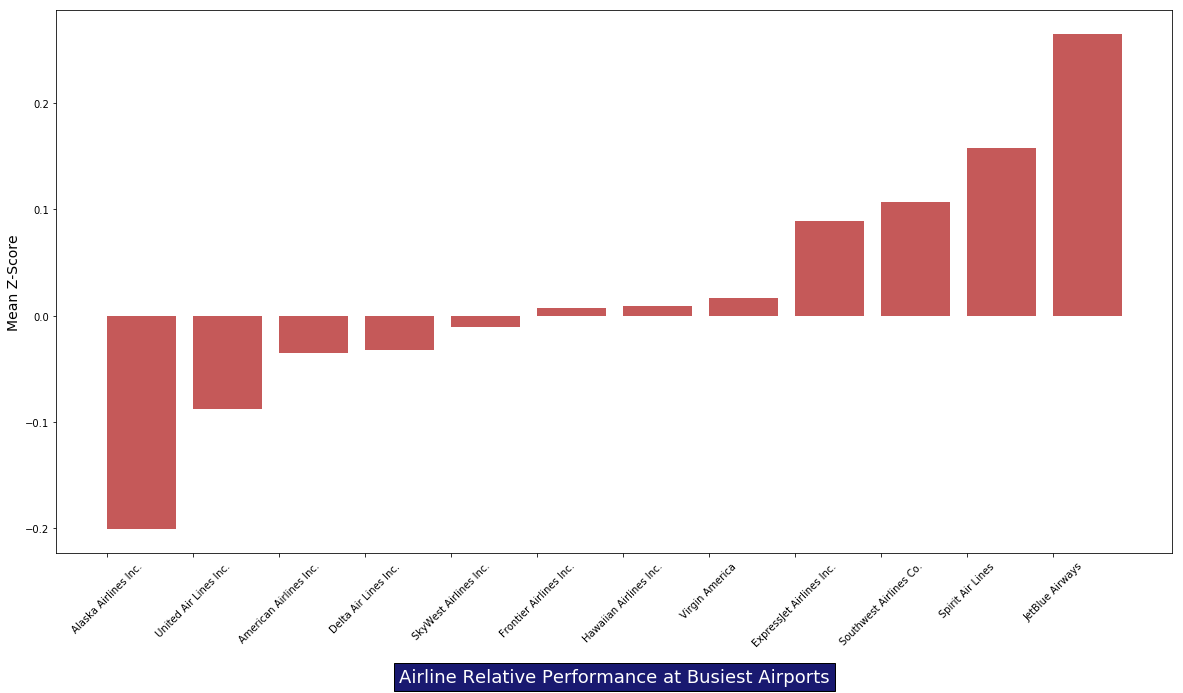

In [15]:
#calc avg z score by airline

plt.figure(figsize=(20,10))

x_axis = np.arange(0,len(airline_comparison.index))
tick_locations = []
for x in x_axis:
    tick_locations.append(x)


plt.xlabel("Airline Relative Performance at Busiest Airports", fontsize=18, bbox={"facecolor":"midnightblue", "pad":5}, color='w', labelpad=20)
plt.ylabel("Mean Z-Score", fontsize=14)
plt.xticks(rotation=45)

plt.bar(x_axis, airline_comparison["zscore"], facecolor="firebrick", alpha=0.75, align="edge",)
plt.xticks(tick_locations, airline_comparison.index)
plt.show()


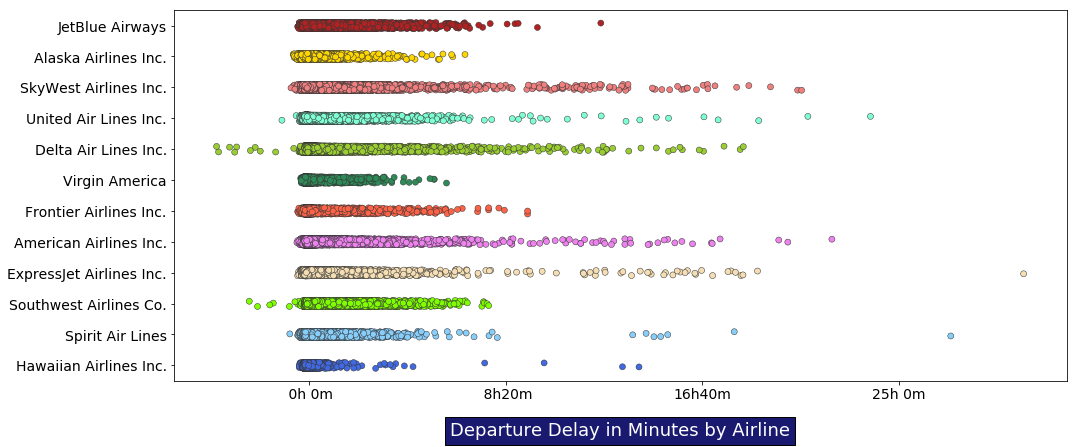

In [18]:
#create df with airlines and delays and replace code with airline name to plot departure delay in minutes by airline
airline_delays["CARRIER"] = airline_delays["CARRIER"].replace(abbr_carrier)

fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)
ax=fig.add_subplot(gs[0,:])

colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'yellowgreen', 
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']

ax = sns.stripplot(y="CARRIER", x="DEP_DELAY", size=6, palette=colors, data=airline_delays, linewidth=.5, jitter=True)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax.get_xticks()])
ax.yaxis.label.set_visible(False)
plt.xlabel("Departure Delay in Minutes by Airline", fontsize=18, bbox={"facecolor":"midnightblue", "pad":5}, color='w', labelpad=20)
#plt.figure(figsize=(20,10))
plt.savefig('delay_in_min_by_airline.png')
plt.show()


In [3]:
#create another dataframe with the flight data for next round of analysis
sns.set_palette("deep", desat=.6)
colors = sns.color_palette("deep")
sns.set_context(rc={"figure.figsize": (50, 20)})
pd.set_option('display.max_columns', 500)
transit_csv= "data.csv"
transit_df = pd.read_csv(transit_csv)

In [4]:
transit_df.count()

YEAR                     458727
QUARTER                  458727
MONTH                    458727
DAY_OF_MONTH             458727
DAY_OF_WEEK              458727
FL_DATE                  458727
UNIQUE_CARRIER           458727
AIRLINE_ID               458727
CARRIER                  458727
TAIL_NUM                 453796
FL_NUM                   458727
ORIGIN_AIRPORT_ID        458727
ORIGIN_AIRPORT_SEQ_ID    458727
ORIGIN_CITY_MARKET_ID    458727
ORIGIN                   458727
HUB_SIZE                 458174
ORIGIN_CITY_NAME         458727
ORIGIN_STATE_ABR         458727
ORIGIN_STATE_FIPS        458727
ORIGIN_STATE_NM          458727
ORIGIN_WAC               458727
DEST_AIRPORT_ID          458727
DEST_AIRPORT_SEQ_ID      458727
DEST_CITY_MARKET_ID      458727
DEST                     458727
DEST_HUB_SIZE            458176
DEST_CITY_NAME           458727
DEST_STATE_ABR           458727
DEST_STATE_FIPS          458727
DEST_STATE_NM            458727
                          ...  
DEP_DELA

In [9]:
#remove NaN entries
transit_df.fillna(0, inplace=True)
transit_df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,HUB_SIZE,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_HUB_SIZE,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME
0,2017,3,9,25,1,9/25/2017,B6,20409,B6,N766JB,1036,14843,1484304,34819,SJU,M,"San Juan, PR",PR,72,Puerto Rico,3,15024,1502403,34945,STT,S,"Charlotte Amalie, VI",VI,78,U.S. Virgin Islands,4,1439,0.0,0.0,0.0,0.0,0.0,1400-1459,0.0,0.0,0.0,0.0,1512,0.0,0.0,0.0,0.0,0.0,1500-1559,1,C,0,33,0.0,0.0,1,68,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017,3,9,25,1,9/25/2017,B6,20409,B6,N834JB,1038,10423,1042302,30423,AUS,M,"Austin, TX",TX,48,Texas,74,10721,1072102,30721,BOS,L,"Boston, MA",MA,25,Massachusetts,13,1811,1801.0,-10.0,0.0,0.0,-1.0,1800-1859,23.0,1824.0,2255.0,8.0,2305,2303.0,-2.0,0.0,0.0,-1.0,2300-2359,0,0,0,234,242.0,211.0,1,1698,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017,3,9,25,1,9/25/2017,B6,20409,B6,N834JB,1039,10721,1072102,30721,BOS,L,"Boston, MA",MA,25,Massachusetts,13,10423,1042302,30423,AUS,M,"Austin, TX",TX,48,Texas,74,705,701.0,-4.0,0.0,0.0,-1.0,0700-0759,16.0,717.0,951.0,7.0,1024,958.0,-26.0,0.0,0.0,-2.0,1000-1059,0,0,0,259,237.0,214.0,1,1698,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017,3,9,25,1,9/25/2017,B6,20409,B6,N571JB,1041,12478,1247803,31703,JFK,L,"New York, NY",NY,36,New York,22,14685,1468502,34685,SAV,S,"Savannah, GA",GA,13,Georgia,34,1559,1552.0,-7.0,0.0,0.0,-1.0,1500-1559,35.0,1627.0,1806.0,7.0,1827,1813.0,-14.0,0.0,0.0,-1.0,1800-1859,0,0,0,148,141.0,99.0,1,718,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017,3,9,25,1,9/25/2017,B6,20409,B6,N571JB,1042,14685,1468502,34685,SAV,S,"Savannah, GA",GA,13,Georgia,34,12478,1247803,31703,JFK,L,"New York, NY",NY,36,New York,22,1916,1902.0,-14.0,0.0,0.0,-1.0,1900-1959,11.0,1913.0,2046.0,9.0,2129,2055.0,-34.0,0.0,0.0,-2.0,2100-2159,0,0,0,133,113.0,93.0,1,718,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
cancels = transit_df.groupby('FL_DATE').CANCELLED.sum()
flights = transit_df.groupby('FL_DATE').FL_DATE.count()
aFlight = (transit_df.groupby('FL_DATE').FL_DATE.count() - transit_df.groupby('FL_DATE').CANCELLED.sum())

In [5]:
weather = transit_df.groupby('FL_DATE').WEATHER_DELAY.sum()
carrier = transit_df.groupby('FL_DATE').CARRIER_DELAY.sum()
nas = transit_df.groupby('FL_DATE').NAS_DELAY.sum()
security = transit_df.groupby('FL_DATE').SECURITY_DELAY.sum()
lateAircraft = transit_df.groupby('FL_DATE').LATE_AIRCRAFT_DELAY.sum()
delays = weather + carrier + nas + security + lateAircraft
destinations = transit_df["DEST_CITY_NAME"].unique()
len(destinations)

288

In [6]:
dates = np.arange(1, 30, 1)
# dte = cancelledByDate
dte = ("1", "2","3", "4", "5", "6", "7", "8", "9", "10",
       "11", "12","13", "14", "15", "16", "17", "18", "19", "20",
       "21", "22","23", "24", "25", "26", "27", "28", "29", "30",)

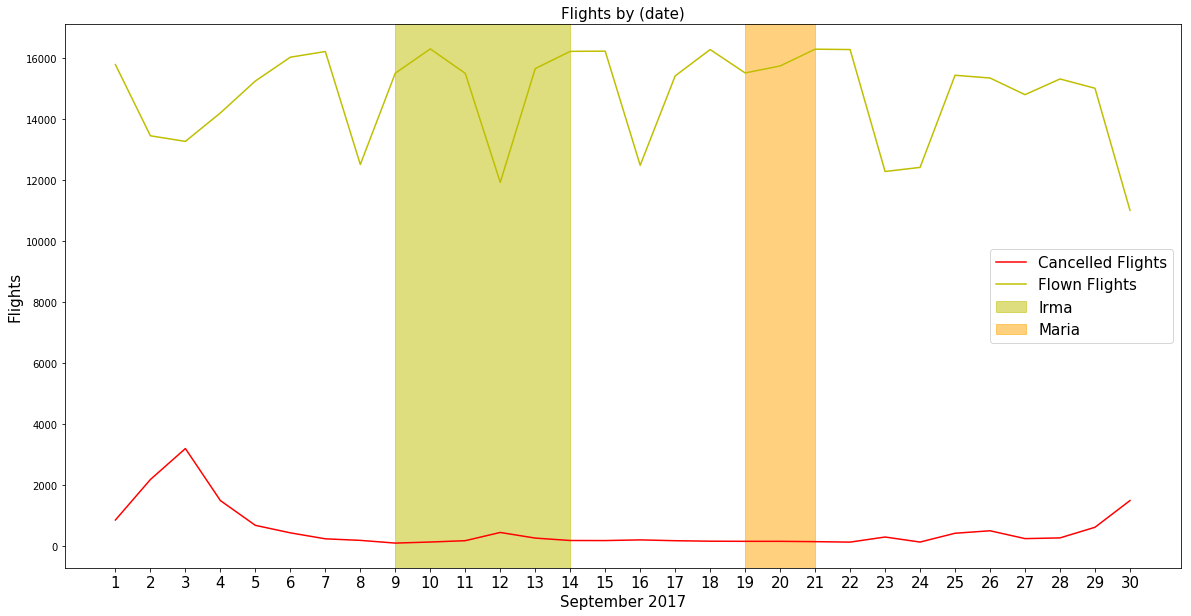

In [7]:
#plot cancellations and flown flights while highlighting major storms in September 2017
index = np.arange(len(dte))#how many things to plot
# plt.plot(<X AXIS VALUES HERE>, <Y AXIS VALUES HERE>, 'line type', label='label here')
# plt.plot(<X AXIS VALUES HERE>, <Y AXIS VALUES HERE>, 'line type', label='label here')
plt.figure(figsize=(20,10))
plt.plot(index, cancels, 'r-', label="Cancelled Flights")
#plt.plot(index, flights, 'b-', label="Attempted Flights")
plt.plot(index, aFlight, 'y-', label="Flown Flights")
#plt.plot(index, delays, 'y-', label="Delays")
plt.xticks(index, dte, fontsize=15)
plt.title('Flights by (date)', fontsize=15)
plt.xlabel('September 2017', fontsize=15)
plt.ylabel('Flights', fontsize=15)
plt.axvspan(8,13,color='y',alpha=0.5, label="Irma")
plt.axvspan(18,20,color='orange',alpha=0.5, label="Maria")
plt.legend(loc='best', fontsize=15)
plt.show()

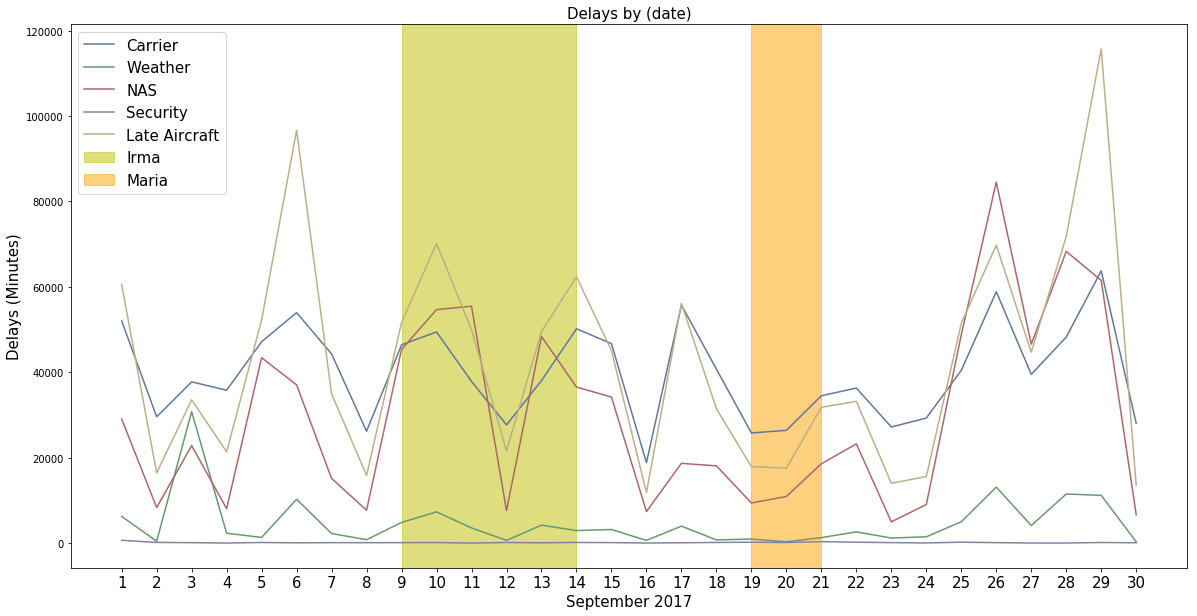

In [8]:
#plot delays by type for the month of September 2017
index = np.arange(len(dte))#how many things to plot
# plt.plot(<X AXIS VALUES HERE>, <Y AXIS VALUES HERE>, 'line type', label='label here')
# plt.plot(<X AXIS VALUES HERE>, <Y AXIS VALUES HERE>, 'line type', label='label here')
# plt.plot(index, delays, 'r-', label="Tot Delays")
plt.figure(figsize=(20,10))
plt.plot(index, carrier, '-', label="Carrier")
plt.plot(index, weather, '-', label="Weather")
plt.plot(index, nas, '-', label="NAS")
plt.plot(index, security, '-', label="Security")
plt.plot(index, lateAircraft, '-', label="Late Aircraft")
plt.xticks(index, dte, fontsize=15)
plt.xlabel('September 2017', fontsize=15)
plt.title('Delays by (date)', fontsize=15)
plt.ylabel('Delays (Minutes)', fontsize=15)
plt.axvspan(8,13,color='y',alpha=0.5, label="Irma")
plt.axvspan(18,20,color='orange',alpha=0.5, label="Maria")
plt.legend(loc='best', fontsize=15)
plt.show()

# Analysis of California

In [13]:
#group by state now and sum the number of delays.
by_origin_state = transit_df.groupby('ORIGIN_STATE_ABR')
departure_delay_counts = by_origin_state.DEP_DEL15.sum()
cancel_delay_counts = by_origin_state.CANCELLED.sum()

In [14]:
by_dest_state = transit_df.groupby('DEST_STATE_ABR')
arrival_delay_counts = by_dest_state.ARR_DEL15.sum()

In [15]:
# Plot, we'll put both series in a DataFrame so we can view the arrival and departure delays for each state
delay_df = pd.DataFrame([departure_delay_counts, arrival_delay_counts, cancel_delay_counts]).T

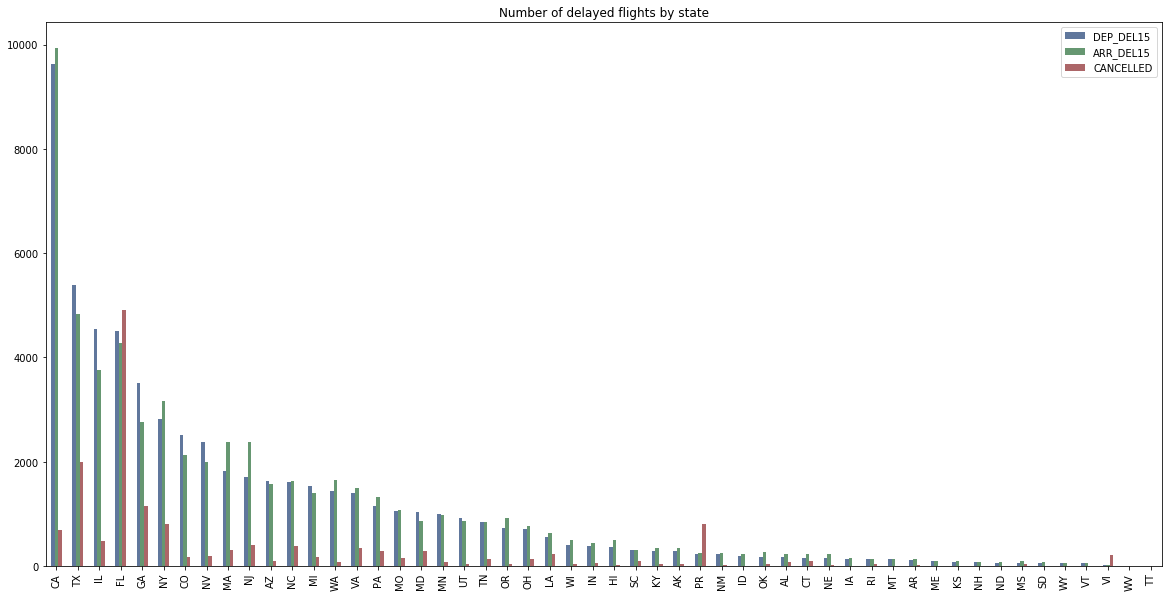

In [16]:
#plot delays and cancellations by state
delay_df.sort_values('DEP_DEL15', ascending=False).plot(kind='bar', title='Number of delayed flights by state', figsize=(20,10))
# plt.figure(figsize=(20,10))
# plt.show()

In [9]:
cali = transit_df.loc[(transit_df["ORIGIN_STATE_ABR"] == "CA")]
cali= cali.reset_index()
cdelay = cali.groupby(["ORIGIN"]).sum()
cdelay = cdelay["DEP_DELAY"]
ccancelled = cali.groupby(["ORIGIN"]).sum()
ccancelled = ccancelled["CANCELLED"]
cdate_delay_count = cali.groupby('FL_DATE')
ca_aFlight = (cali.groupby('FL_DATE').FL_DATE.count() - cali.groupby('FL_DATE').CANCELLED.sum())
cdate_cancels = cali.groupby('FL_DATE').CANCELLED.sum()
cdate_delay_count = cali.loc[(cali["DEP_DEL15"] > 0)]
cdate_delay_count = cdate_delay_count.groupby('FL_DATE').DEP_DEL15.sum()

In [10]:
#analysis of California wildfires

#from pandas.io.html import read_html
#wiki_fires = pd.read_html("https://en.wikipedia.org/wiki/2017_California_wildfires")
#wildfire_df = wiki_fires[1]
#wildfire_df
#wildfire_df.columns = wildfire_df.iloc[0]
#wildfire_df = wildfire_df[1:]
#wildfire_df = wildfire_df.drop(["Notes"],axis=1)
#wildfire_df["Acres"] = wildfire_df["Acres"].astype("int64")
#wildfire_df = wildfire_df.sort_values("Acres",ascending=False)
#wildfire_df = wildfire_df.reset_index()

#read in wildfires data
wildfires_cs = "wildfires.csv"
wildfire_sept = pd.read_csv("wildfires.csv")
wildfire_sept.head(20)

,Name,County,Acres,Start Date,Containment Date
0,Eclipse Complex,Siskiyou,78698,2017-08-15,2017-11-29
1,Salmon August Complex,Siskiyou,65888,2017-06-25,2017-12-08
2,Pier,Tulare,36556,2017-08-29,2017-11-29
3,Orleans Complex,Siskiyou,27276,2017-07-25,2017-09-26
4,Helena,Trinity,21846,2017-08-30,2017-11-15
5,Lion,Tulare,18900,2017-09-24,2017-12-02
6,Whittier,Santa Barbara,18430,2017-07-08,2017-10-05
7,Buck,Trinity,13417,2017-09-12,2017-11-20
8,Railroad,Madera,12407,2017-08-29,2017-10-24
9,Slinkard,Mono,8925,2017-08-29,2017-09-12


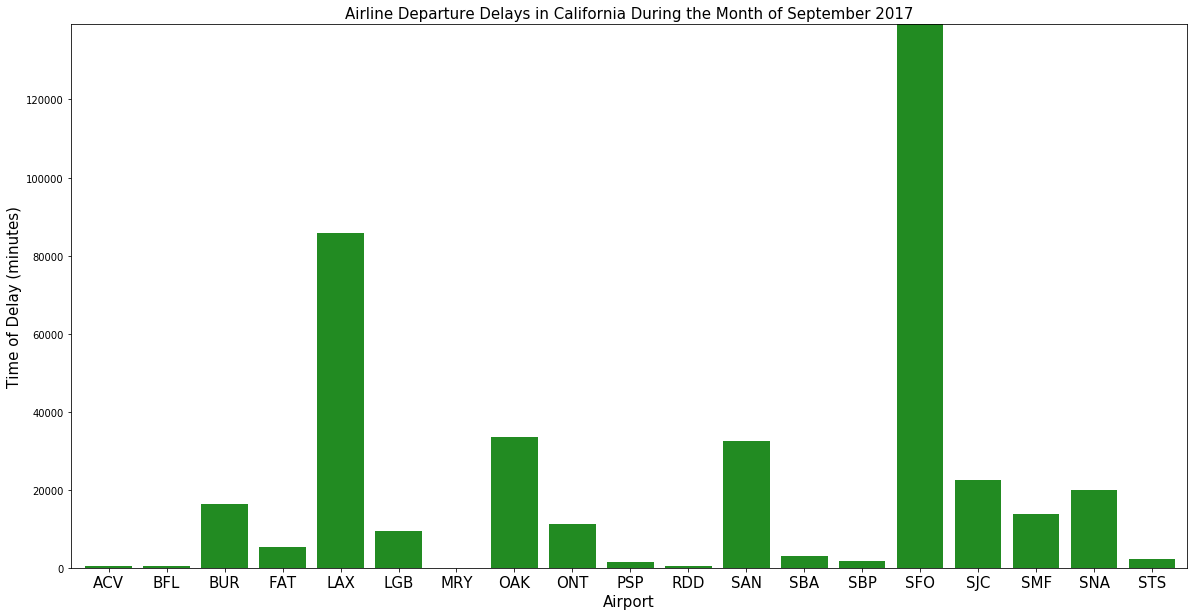

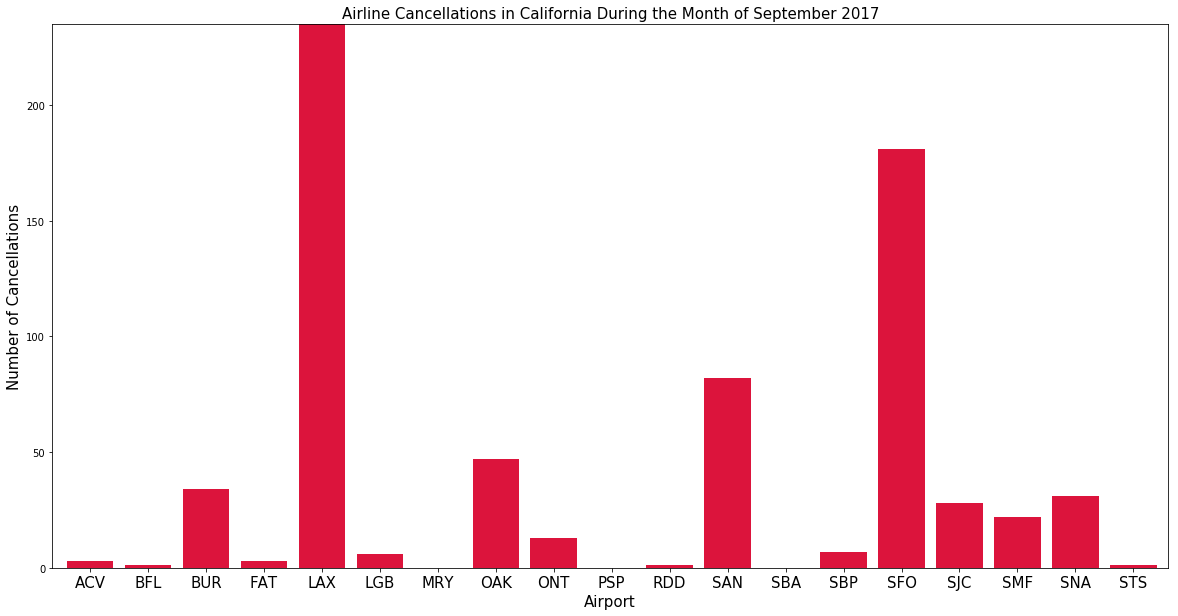

In [11]:
#plot airport departure delays
plt.figure(figsize=(20,10))
airports = ["ACV", "BFL", "BUR", "FAT", "LAX", "LGB","MRY", "OAK", "ONT", "PSP" ,"RDD" ,"SAN", "SBA", "SBP", "SFO", "SJC" ,"SMF", "SNA", "STS"]
x_axis = np.arange(len(cdelay))
barlist = plt.bar(x_axis,cdelay,color="forestgreen",align="edge")
tick_locations = [value+0.4 for value in x_axis]
plt.xticks(tick_locations, airports, fontsize=15)
plt.xlim(-0.25, len(x_axis))
plt.ylim(0, max(cdelay))
plt.title("Airline Departure Delays in California During the Month of September 2017", fontsize=15)
plt.xlabel("Airport", fontsize=15)
plt.ylabel("Time of Delay (minutes)", fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

#plot flight cancellations in California
plt.figure(figsize=(20,10))
airports = ["ACV", "BFL", "BUR", "FAT", "LAX", "LGB","MRY", "OAK", "ONT", "PSP" ,"RDD" ,"SAN", "SBA", "SBP", "SFO", "SJC" ,"SMF", "SNA", "STS"]
x_axis = np.arange(len(ccancelled))
barlist = plt.bar(x_axis,ccancelled,color="crimson",align="edge")
tick_locations = [value+0.4 for value in x_axis]
plt.xticks(tick_locations, airports, fontsize=15)
plt.xlim(-0.25, len(x_axis))
plt.ylim(0, max(ccancelled))
plt.title("Airline Cancellations in California During the Month of September 2017", fontsize=15)
plt.xlabel("Airport", fontsize=15)
plt.ylabel("Number of Cancellations", fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

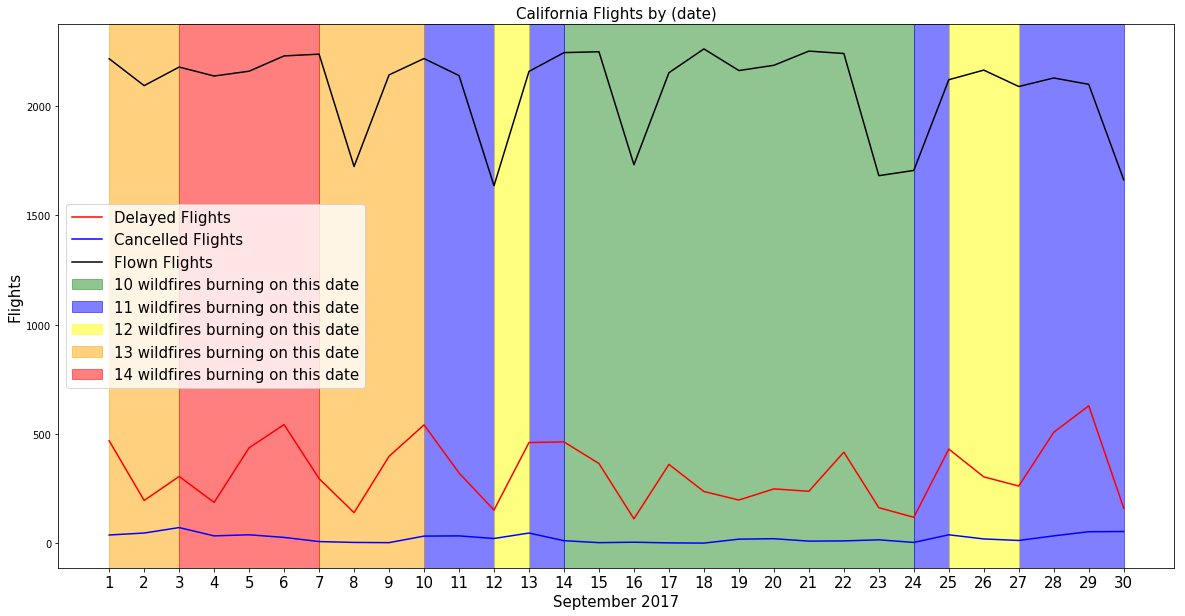

In [24]:
#plot flight cancellations, delayed flights and flown flights in September while highlighting wildfire intesity
index = np.arange(len(dte))
plt.figure(figsize=(20,10))
plt.plot(index, cdate_delay_count, 'r-', label="Delayed Flights")
plt.plot(index, cdate_cancels, "blue", label="Cancelled Flights")
plt.plot(index, ca_aFlight, 'black', label="Flown Flights")
plt.xticks(index, dte, fontsize=15)
plt.title('California Flights by (date)', fontsize=15)
plt.xlabel('September 2017', fontsize=15)
plt.axvspan(13,23,color='forestgreen',alpha=0.5, label="10 wildfires burning on this date")
plt.axvspan(26,29,color='blue',alpha=0.5, label="11 wildfires burning on this date")
plt.axvspan(9,11,color='blue',alpha=0.5)
plt.axvspan(12,13,color='blue',alpha=0.5)
plt.axvspan(23,24,color='blue',alpha=0.5)
plt.axvspan(11,12,color='yellow',alpha=0.5, label="12 wildfires burning on this date")
plt.axvspan(24,26, color='yellow',alpha=0.5,)
plt.axvspan(0,2,color='orange',alpha=0.5, label="13 wildfires burning on this date")
plt.axvspan(6,9,color='orange',alpha=0.5)
plt.axvspan(2,6,color='red',alpha=0.5, label="14 wildfires burning on this date")
plt.ylabel('Flights', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.show()

Appendix information facts and fiction

Carrier Delay
Carrier delay is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.
Late Arrival Delay
Arrival delay at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.
NAS Delay
Delay that is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc. Delays that occur after Actual Gate Out are usually attributed to the NAS and are also reported through OPSNET.
Security Delay
Security delay is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.
Weather Delay
Weather delay is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival.
OPSNET Delay Cause
Delays to Instrument Flight Rules (IFR) traffic of 15 minutes or more, experienced by individual flights, which result from the ATC system detaining an aircraft at the gate, short of the runway, on the runway, on a taxiway, and/or in a holding configuration anywhere en route.
Such delays include delays due to weather conditions at airports and en route (Weather), FAA and non-FAA equipment malfunctions (Equipment), the volume of traffic at an airport (Volume), reduction to runway capacity (Runway), and other factors (Others). Flight delays of less than 15 minutes are not reported in OPSNET. ASPM reports the most dominant OPSNET delay cause for any flight with an ASQP Reported NAS Delay.
A flight is considered delayed when it arrived 15 or more minutes than the schedule (see definitions in Frequently Asked Questions). Delayed minutes are calculated for delayed flights only.
When multiple causes are assigned to one delayed flight, each cause is prorated based on delayed minutes it is responsible for. The displayed numbers are rounded and may not add up to the total.
SOURCE: Bureau of Transportation Statistics, Airline Service Quality Performance 234

In [31]:
#function to return conditions
def get_conditions(readDate):
    api_conditions_url = "http://api.wunderground.com/api/" + WUNDERGROUND_API_KEY + "/history_" + readDate + "/q/" + STATE +"/"+ CITY + ".json"
    try:
        f = requests.get(api_conditions_url).json()
        print(api_conditions_url)
    except:
        print("Failed to get conditions")
        return False
    if CITY == "SCE":
        return False
    else:
        return f

In [12]:
#read csv again
csv_path = "data.csv"
weather_df = pd.read_csv(csv_path, low_memory=False)
weather_df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,HUB_SIZE,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_HUB_SIZE,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME
0,2017,3,9,25,1,9/25/2017,B6,20409,B6,N766JB,1036,14843,1484304,34819,SJU,M,"San Juan, PR",PR,72,Puerto Rico,3,15024,1502403,34945,STT,S,"Charlotte Amalie, VI",VI,78,U.S. Virgin Islands,4,1439,NaN,NaN,NaN,NaN,NaN,1400-1459,NaN,NaN,NaN,NaN,1512,NaN,NaN,NaN,NaN,NaN,1500-1559,1,C,0,33,NaN,NaN,1,68,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017,3,9,25,1,9/25/2017,B6,20409,B6,N834JB,1038,10423,1042302,30423,AUS,M,"Austin, TX",TX,48,Texas,74,10721,1072102,30721,BOS,L,"Boston, MA",MA,25,Massachusetts,13,1811,1801.0,-10.0,0.0,0.0,-1.0,1800-1859,23.0,1824.0,2255.0,8.0,2305,2303.0,-2.0,0.0,0.0,-1.0,2300-2359,0,NaN,0,234,242.0,211.0,1,1698,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,3,9,25,1,9/25/2017,B6,20409,B6,N834JB,1039,10721,1072102,30721,BOS,L,"Boston, MA",MA,25,Massachusetts,13,10423,1042302,30423,AUS,M,"Austin, TX",TX,48,Texas,74,705,701.0,-4.0,0.0,0.0,-1.0,0700-0759,16.0,717.0,951.0,7.0,1024,958.0,-26.0,0.0,0.0,-2.0,1000-1059,0,NaN,0,259,237.0,214.0,1,1698,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,3,9,25,1,9/25/2017,B6,20409,B6,N571JB,1041,12478,1247803,31703,JFK,L,"New York, NY",NY,36,New York,22,14685,1468502,34685,SAV,S,"Savannah, GA",GA,13,Georgia,34,1559,1552.0,-7.0,0.0,0.0,-1.0,1500-1559,35.0,1627.0,1806.0,7.0,1827,1813.0,-14.0,0.0,0.0,-1.0,1800-1859,0,NaN,0,148,141.0,99.0,1,718,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,3,9,25,1,9/25/2017,B6,20409,B6,N571JB,1042,14685,1468502,34685,SAV,S,"Savannah, GA",GA,13,Georgia,34,12478,1247803,31703,JFK,L,"New York, NY",NY,36,New York,22,1916,1902.0,-14.0,0.0,0.0,-1.0,1900-1959,11.0,1913.0,2046.0,9.0,2129,2055.0,-34.0,0.0,0.0,-2.0,2100-2159,0,NaN,0,133,113.0,93.0,1,718,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# CREATE CHART WITH WEATHER

In [33]:
weather_delays_df = weather_df.loc[((weather_df["WEATHER_DELAY"] > 0)) & ((weather_df["ORIGIN"]=="PHL") | (weather_df["ORIGIN"]=="DFW") | (weather_df["ORIGIN"]=="BOS") | (weather_df["ORIGIN"]=="JFK") | (weather_df["ORIGIN"]=="IAH") | (weather_df["ORIGIN"]=="DEN") | (weather_df["ORIGIN"]=="LGA") | (weather_df["ORIGIN"]=="ORD") | (weather_df["ORIGIN"]=="EWR") | (weather_df["ORIGIN"]=="SFO") | (weather_df["DEST"]=="PHL") | (weather_df["DEST"]=="DFW") | (weather_df["DEST"]=="BOS") | (weather_df["DEST"]=="JFK") | (weather_df["DEST"]=="IAH") | (weather_df["DEST"]=="DEN") | (weather_df["DEST"]=="LGA") | (weather_df["DEST"]=="ORD") | (weather_df["DEST"]=="EWR") | (weather_df["DEST"]=="SFO")) & (weather_df["DEST"]!="OMA") & (weather_df["ORIGIN"]!="OMA"),:]
weather_delays_df.reset_index(inplace=True)
weather_delays_df.head()

,index,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,...,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME
0,1293,2017,3,9,27,3,9/27/2017,B6,20409,B6,...,2602,11,0.0,68.0,7.0,0.0,0.0,1758.0,42.0,42.0
1,1670,2017,3,9,27,3,9/27/2017,B6,20409,B6,...,173,1,0.0,18.0,0.0,0.0,0.0,NaN,NaN,NaN
2,1872,2017,3,9,28,4,9/28/2017,B6,20409,B6,...,1065,5,0.0,81.0,15.0,0.0,0.0,NaN,NaN,NaN
3,2129,2017,3,9,28,4,9/28/2017,B6,20409,B6,...,1065,5,0.0,44.0,6.0,0.0,0.0,NaN,NaN,NaN
4,3080,2017,3,9,29,5,9/29/2017,B6,20409,B6,...,1028,5,0.0,24.0,0.0,0.0,0.0,NaN,NaN,NaN


In [142]:
weather_map_df = pd.DataFrame(weather_delays_df.loc[:,["YEAR", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK",
                                          "FL_DATE","CARRIER","ORIGIN","ORIGIN_STATE_ABR","DEST","DEST_STATE_ABR","DEP_TIME","CRS_ARR_TIME","WEATHER_DELAY","CANCELLATION_CODE"]])
weather_map_df.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,DEP_TIME,CRS_ARR_TIME,WEATHER_DELAY,CANCELLATION_CODE
0,2017,9,27,3,9/27/2017,B6,BOS,MA,LGB,CA,1916.0,2131,68.0,NaN
1,2017,9,27,3,9/27/2017,B6,JFK,NY,MVY,MA,1154.0,1229,18.0,NaN
2,2017,9,28,4,9/28/2017,B6,FLL,FL,EWR,NJ,1942.0,2114,81.0,NaN
3,2017,9,28,4,9/28/2017,B6,FLL,FL,EWR,NJ,1302.0,1513,44.0,NaN
4,2017,9,29,5,9/29/2017,B6,PBI,FL,JFK,NY,1647.0,1900,24.0,NaN


In [7]:
#create columns for weather conditions to be pulled
weather_map_df["Conds_Description"] = "conds"
weather_map_df["Visibility"] = 0.0
weather_map_df["Pressure"] = 0.0
weather_map_df["Precipitation"] = 0.0
weather_map_df["Wind"] = 0.0
weather_map_df["Wind_Gust"] = 0.0 
weather_map_df["Fog"] = 0.0
weather_map_df["Snow"] = 0.0
weather_map_df["Temp"] = 0.0
weather_map_df["Thunder"] = 0.0
weather_map_df["Tornado"] = 0.0
weather_map_df["Rain"] = 0.0
weather_map_df["Hail"] = 0.0

weather_map_df["Dest_Conds_Description"] = "conds"
weather_map_df["Dest_Visibility"] = 0.0
weather_map_df["Dest_Pressure"] = 0.0
weather_map_df["Dest_Precipitation"] = 0.0
weather_map_df["Dest_Wind"] = 0.0
weather_map_df["Dest_Wind_Gust"] = 0.0 
weather_map_df["Dest_Fog"] = 0.0
weather_map_df["Dest_Snow"] = 0.0
weather_map_df["Dest_Temp"] = 0.0
weather_map_df["Dest_Thunder"] = 0.0
weather_map_df["Dest_Tornado"] = 0.0
weather_map_df["Dest_Rain"] = 0.0
weather_map_df["Dest_Hail"] = 0.0

In [143]:
#wunderground keys
STARTDATE2 = ""
WUNDERGROUND_API_KEY = "aa2877982956f024"
BUCKET_KEY = "wu1"
ACCESS_KEY = "aa2877982956f024"

#loop through weather delays
weather_delays_count = len(weather_map_df)
for row in range(weather_delays_count-1):
    STATE = weather_map_df.iloc[row]["ORIGIN_STATE_ABR"]
    CITY = weather_map_df.iloc[row]["ORIGIN"]
    row_year = int(weather_map_df.iloc[row]["YEAR"])
    row_month = int(weather_map_df.iloc[row]["MONTH"])
    row_day = int(weather_map_df.iloc[row]["DAY_OF_MONTH"])
    
    STARTDATE2 = date(row_year,row_month,row_day)
    
    date_wu = []
    humidity_wu = []
    temp_wu = []
    pressure_wu = []
    precip_wu = []
    wind_speed_wu = []
    dewpt_wu = []
    wind_gust_wu = []
    wind_dir_wu = []
    vis_wu = []
    wind_chill_wu = []
    heat_index_wu = []
    conds_wu = []
    fog_wu = []
    rain_wu = []
    snow_wu = []
    hail_wu = []
    thunder_wu = []
    tornado_wu = []
    
    dest_date_wu = []
    dest_humidity_wu = []
    dest_temp_wu = []
    dest_pressure_wu = []
    dest_precip_wu = []
    dest_wind_speed_wu = []
    dest_dewpt_wu = []
    dest_wind_gust_wu = []
    dest_wind_dir_wu = []
    dest_vis_wu = []
    dest_wind_chill_wu = []
    dest_heat_index_wu = []
    dest_conds_wu = []
    dest_fog_wu = []
    dest_rain_wu = []
    dest_snow_wu = []
    dest_hail_wu = []
    dest_thunder_wu = []
    dest_tornado_wu = []

    #pull conditions for origin city on day of flight
    conditions = get_conditions(STARTDATE2.strftime("%Y%m%d"))

    if (conditions != False):
        for i in range(len(conditions['history']['observations'])):
            dateInfo = conditions['history']['observations'][i]['date']
            date_holder = dateInfo['mon']+"/"+dateInfo['mday']+"/"+dateInfo['year']+" "+dateInfo['hour']+dateInfo['min']
            pattern = '%m/%d/%Y %H%M'
            date_wu.append(date_holder)
            epoch = int(time.mktime(time.strptime(date_holder, pattern)))

            humidity_wu.append(conditions['history']['observations'][i]['hum'])
            temp_wu.append(conditions['history']['observations'][i]['tempi'])
            pressure_wu.append(conditions['history']['observations'][i]['pressurei'])
            precip_wu.append(conditions['history']['observations'][i]['precipi'])
            wind_speed_wu.append(conditions['history']['observations'][i]['wspdi'])
            dewpt_wu.append(conditions['history']['observations'][i]['dewpti'])
            wind_gust_wu.append(conditions['history']['observations'][i]['wgusti'])
            wind_dir_wu.append(conditions['history']['observations'][i]['wdird'])
            vis_wu.append(conditions['history']['observations'][i]['visi'])
            wind_chill_wu.append(conditions['history']['observations'][i]['windchilli'])
            heat_index_wu.append(conditions['history']['observations'][i]['heatindexi'])
            conds_wu.append(conditions['history']['observations'][i]['conds'])
            fog_wu.append(conditions['history']['observations'][i]['fog'])
            rain_wu.append(conditions['history']['observations'][i]['rain'])
            snow_wu.append(conditions['history']['observations'][i]['snow'])
            hail_wu.append(conditions['history']['observations'][i]['hail'])
            thunder_wu.append(conditions['history']['observations'][i]['thunder'])
            tornado_wu.append(conditions['history']['observations'][i]['tornado'])

        obs_df = pd.DataFrame({
            "Date":date_wu,
            "Temp":temp_wu,
            "Pressure":pressure_wu,
            "Precipitation":precip_wu,
            "Wind_Gust":wind_gust_wu,
            "Wind":wind_speed_wu,
            "Visibility":vis_wu,
            "Conds_Description":conds_wu,
            "Fog":fog_wu,
            "Rain":rain_wu,
            "Snow":snow_wu,
            "Hail":hail_wu,
            "Thunder":thunder_wu,
            "Tornado":tornado_wu
        })

        #find the closest observation to the scheduled flight time
        military_time = int(weather_map_df.iloc[row]["DEP_TIME"])
        if military_time < 1000:
            time_str = "0" + str(military_time)
        else:
            time_str = str(military_time)

        rcd_time = str(row_month) + "/" + str(row_day) + "/" + str(row_year) + " " + str(time_str)
        rec_time = datetime.strptime(rcd_time, '%m/%d/%Y %H%M')

        closest_time = rec_time
        min_diff = 99999999999

        converted_timestamps = []
        for raw_time in date_wu:
            converted_time = datetime.strptime(raw_time, '%m/%d/%Y %H%M')
            converted_timestamps.append(converted_time)
            diff = rec_time - converted_time
            if diff.seconds < min_diff:
                min_diff = diff.seconds
                closest_time = converted_time

        closest = closest_time.strftime("%m/%d/%Y %H%M")        

        #add conditions closest to departure time to main data frame
        observation = obs_df.loc[obs_df["Date"]==closest,:]
        observation_fog = observation["Fog"]
        observation_pressure = observation["Pressure"]
        observation_snow = observation["Snow"]
        observation_temp = observation["Temp"]
        observation_thunder = observation["Thunder"]
        observation_wind = observation["Wind"]
        observation_wind_gust = observation["Wind_Gust"]
        observation_rain = observation["Rain"]
        observation_tornado = observation["Tornado"]
        observation_visibility = observation["Visibility"]
        observation_conds_description = observation["Conds_Description"]
        observation_precipitation = observation["Precipitation"]
        observation_hail = observation["Hail"]

        weather_map_df.loc[row,"Fog"] = float(observation_fog)
        weather_map_df.loc[row,"Pressure"] = float(observation_pressure)
        weather_map_df.loc[row,"Snow"] = float(observation_snow)
        weather_map_df.loc[row,"Temp"] = float(observation_temp)
        weather_map_df.loc[row,"Thunder"] = float(observation_thunder)
        weather_map_df.loc[row,"Wind"] = float(observation_wind)
        weather_map_df.loc[row,"Wind_Gust"] = float(observation_wind_gust)
        weather_map_df.loc[row,"Rain"] = float(observation_rain)
        weather_map_df.loc[row,"Tornado"] = float(observation_tornado)
        weather_map_df.loc[row,"Visibility"] = float(observation_visibility)
        weather_map_df.loc[row,"Conds_Description"] = str(observation_conds_description)
        weather_map_df.loc[row,"Hail"] = float(observation_hail)

    #get destination conditions - same process as above
    STATE = weather_map_df.iloc[row]["DEST_STATE_ABR"]
    CITY = weather_map_df.iloc[row]["DEST"]  
             
    dest_conditions = get_conditions(STARTDATE2.strftime("%Y%m%d"))
    
    if (dest_conditions != False):
        for i in range(len(dest_conditions['history']['observations'])):
            dateInfo = dest_conditions['history']['observations'][i]['date']
            date_holder = dateInfo['mon']+"/"+dateInfo['mday']+"/"+dateInfo['year']+" "+dateInfo['hour']+dateInfo['min']
            pattern = '%m/%d/%Y %H%M'
            dest_date_wu.append(date_holder)
            epoch = int(time.mktime(time.strptime(date_holder, pattern)))

            dest_humidity_wu.append(dest_conditions['history']['observations'][i]['hum'])
            dest_temp_wu.append(dest_conditions['history']['observations'][i]['tempi'])
            dest_pressure_wu.append(dest_conditions['history']['observations'][i]['pressurei'])
            dest_precip_wu.append(dest_conditions['history']['observations'][i]['precipi'])
            dest_wind_speed_wu.append(dest_conditions['history']['observations'][i]['wspdi'])
            dest_dewpt_wu.append(dest_conditions['history']['observations'][i]['dewpti'])
            dest_wind_gust_wu.append(dest_conditions['history']['observations'][i]['wgusti'])
            dest_wind_dir_wu.append(dest_conditions['history']['observations'][i]['wdird'])
            dest_vis_wu.append(dest_conditions['history']['observations'][i]['visi'])
            dest_wind_chill_wu.append(dest_conditions['history']['observations'][i]['windchilli'])
            dest_heat_index_wu.append(dest_conditions['history']['observations'][i]['heatindexi'])
            dest_conds_wu.append(dest_conditions['history']['observations'][i]['conds'])
            dest_fog_wu.append(dest_conditions['history']['observations'][i]['fog'])
            dest_rain_wu.append(dest_conditions['history']['observations'][i]['rain'])
            dest_snow_wu.append(dest_conditions['history']['observations'][i]['snow'])
            dest_hail_wu.append(dest_conditions['history']['observations'][i]['hail'])
            dest_thunder_wu.append(dest_conditions['history']['observations'][i]['thunder'])
            dest_tornado_wu.append(dest_conditions['history']['observations'][i]['tornado'])

        dest_obs_df = pd.DataFrame({
            "Date":dest_date_wu,
            "Temp":dest_temp_wu,
            "Pressure":dest_pressure_wu,
            "Precipitation":dest_precip_wu,
            "Wind_Gust":dest_wind_gust_wu,
            "Wind":dest_wind_speed_wu,
            "Visibility":dest_vis_wu,
            "Conds_Description":dest_conds_wu,
            "Fog":dest_fog_wu,
            "Rain":dest_rain_wu,
            "Snow":dest_snow_wu,
            "Hail":dest_hail_wu,
            "Thunder":dest_thunder_wu,
            "Tornado":dest_tornado_wu
        })

        military_time = int(weather_map_df.iloc[row]["CRS_ARR_TIME"])
        if military_time < 1000:
            time_str = "0" + str(military_time)
        else:
            time_str = str(military_time)

        closest_time = rec_time
        min_diff = 99999999999

        converted_timestamps = []
        for raw_time in dest_date_wu:
            converted_time = datetime.strptime(raw_time, '%m/%d/%Y %H%M')
            converted_timestamps.append(converted_time)
            diff = rec_time - converted_time
            if diff.seconds < min_diff:
                min_diff = diff.seconds
                closest_time = converted_time

        closest = closest_time.strftime("%m/%d/%Y %H%M")        

        observation = dest_obs_df.loc[dest_obs_df["Date"]==closest,:]
        observation_fog = observation["Fog"]
        observation_pressure = observation["Pressure"]
        observation_snow = observation["Snow"]
        observation_temp = observation["Temp"]
        observation_thunder = observation["Thunder"]
        observation_wind = observation["Wind"]
        observation_wind_gust = observation["Wind_Gust"]
        observation_rain = observation["Rain"]
        observation_tornado = observation["Tornado"]
        observation_visibility = observation["Visibility"]
        observation_conds_description = observation["Conds_Description"]
        observation_precipitation = observation["Precipitation"]
        observation_hail = observation["Hail"]

        weather_map_df.loc[row,"Dest_Fog"] = float(observation_fog)
        weather_map_df.loc[row,"Dest_Pressure"] = float(observation_pressure)
        weather_map_df.loc[row,"Dest_Snow"] = float(observation_snow)
        weather_map_df.loc[row,"Dest_Temp"] = float(observation_temp)
        weather_map_df.loc[row,"Dest_Thunder"] = float(observation_thunder)
        weather_map_df.loc[row,"Dest_Wind"] = float(observation_wind)
        weather_map_df.loc[row,"Dest_Wind_Gust"] = float(observation_wind_gust)
        weather_map_df.loc[row,"Dest_Rain"] = float(observation_rain)
        weather_map_df.loc[row,"Dest_Tornado"] = float(observation_tornado)
        weather_map_df.loc[row,"Dest_Visibility"] = float(observation_visibility)
        weather_map_df.loc[row,"Dest_Conds_Description"] = str(observation_conds_description)
        weather_map_df.loc[row,"Dest_Hail"] = float(observation_hail)
        
weather_map_df
#error as a result of api usage

http://api.wunderground.com/api/aa2877982956f024/history_20170927/q/MA/BOS.json


KeyError: 'history'

In [37]:
#save file to csv - start next block of code based on most records received before limit reached
weather_map_df.to_csv("Book2.csv", index=False, header=True)

In [141]:
weather_map_df.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,...,Dest_Snow,Dest_Temp,Dest_Thunder,Dest_Wind,Dest_Wind_Gust,Dest_Rain,Dest_Tornado,Dest_Visibility,Dest_Conds_Description,Dest_Hail
0,2017,9,27,3,9/27/2017,B6,BOS,MA,LGB,CA,...,0.0,72.0,0.0,11.5,-9999.0,0.0,0.0,10.0,"31 Clear\nName: Conds_Description, dtype: o...",0.0
1,2017,9,27,3,9/27/2017,B6,JFK,NY,MVY,MA,...,0.0,73.9,0.0,6.9,-9999.0,0.0,0.0,10.0,"37 Overcast\nName: Conds_Description, dtype...",0.0
2,2017,9,28,4,9/28/2017,B6,FLL,FL,EWR,NJ,...,0.0,70.0,0.0,23.0,33.4,0.0,0.0,10.0,"21 Partly Cloudy\nName: Conds_Description, ...",0.0
3,2017,9,28,4,9/28/2017,B6,FLL,FL,EWR,NJ,...,0.0,78.1,0.0,21.9,27.6,0.0,0.0,10.0,"15 Partly Cloudy\nName: Conds_Description, ...",0.0
4,2017,9,29,5,9/29/2017,B6,PBI,FL,JFK,NY,...,0.0,64.9,0.0,15.0,-9999.0,0.0,0.0,10.0,"15 Mostly Cloudy\nName: Conds_Description, ...",0.0


# PETE'S CODE

In [6]:
### Read in CSV and elminate rows where measurements do not  make sense
weather_map_df = pd.read_csv("Book2.csv")
weather_map_df = weather_map_df[weather_map_df.Temp != 0]
weather_map_df = weather_map_df[weather_map_df.Pressure != 0]
weather_map_df.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,DEP_TIME,WEATHER_DELAY,CANCELLATION_CODE,Conds_Description,Visibility,Pressure,Precipitation,Wind,Wind_Gust,Fog,Snow,Temp,Thunder,Tornado,Rain,Hail,Dest_Conds_Description,Dest_Visibility,Dest_Pressure,Dest_Precipitation,Dest_Wind,Dest_Wind_Gust,Dest_Fog,Dest_Snow,Dest_Temp,Dest_Thunder,Dest_Tornado,Dest_Rain,Dest_Hail
0,2017,9,27,3,9/27/2017,B6,BOS,MA,LGB,CA,1916,68,NaN,18 Partly Cloudy\r\nName: Conds_Description...,10.0,29.80,0,11.5,-9999.0,0,0,80.1,0,0,0,0,"31 Clear\r\nName: Conds_Description, dtype:...",10.0,29.85,0,11.5,-9999.0,0,0,72.0,0,0,0,0
1,2017,9,27,3,9/27/2017,B6,JFK,NY,MVY,MA,1154,18,NaN,16 Mostly Cloudy\r\nName: Conds_Description...,10.0,29.90,0,9.2,-9999.0,0,0,82.9,0,0,0,0,"37 Overcast\r\nName: Conds_Description, dty...",10.0,29.92,0,6.9,-9999.0,0,0,73.9,0,0,0,0
2,2017,9,28,4,9/28/2017,B6,FLL,FL,EWR,NJ,1942,81,NaN,"18 Overcast\r\nName: Conds_Description, dty...",10.0,29.86,0,9.2,-9999.0,0,0,82.9,0,0,0,0,21 Partly Cloudy\r\nName: Conds_Description...,10.0,29.86,0,23.0,33.4,0,0,70.0,0,0,0,0
3,2017,9,28,4,9/28/2017,B6,FLL,FL,EWR,NJ,1302,44,NaN,12 Partly Cloudy\r\nName: Conds_Description...,10.0,29.89,0,12.7,-9999.0,0,0,88.0,0,0,0,0,15 Partly Cloudy\r\nName: Conds_Description...,10.0,29.77,0,21.9,27.6,0,0,78.1,0,0,0,0
4,2017,9,29,5,9/29/2017,B6,PBI,FL,JFK,NY,1647,24,NaN,22 Light Thunderstorms and Rain\r\nName: Co...,7.0,29.88,0,6.9,-9999.0,0,0,75.9,1,0,1,0,15 Mostly Cloudy\r\nName: Conds_Description...,10.0,30.01,0,15.0,-9999.0,0,0,64.9,0,0,0,0


In [7]:
### Create new df with only oberservations to be analyzed
plots = pd.DataFrame(weather_map_df.loc[:,["WEATHER_DELAY","Wind","Pressure","Fog","Visibility","Temp"]])

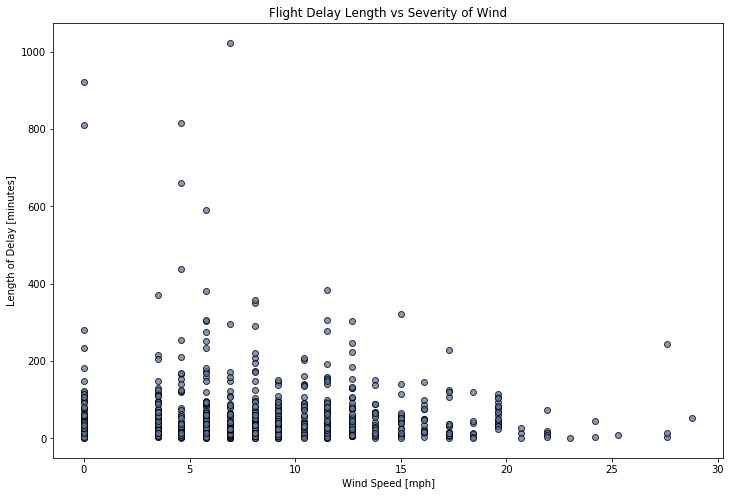

In [8]:
### Create scatterplots

import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.scatter(plots["Wind"],plots["WEATHER_DELAY"],
            alpha = 0.75,
            edgecolor = "black")
plt.title("Flight Delay Length vs Severity of Wind")
plt.xlabel("Wind Speed [mph]")
plt.ylabel("Length of Delay [minutes]")
plt.show()

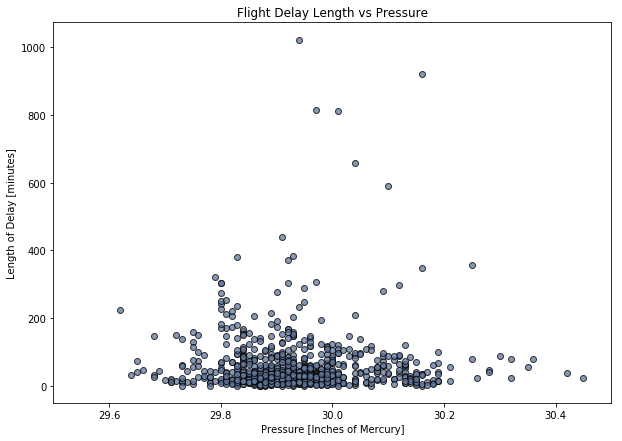

In [9]:
plt.figure(figsize= (10,7))
plt.scatter(plots["Pressure"],plots["WEATHER_DELAY"],
            alpha = 0.75,
            edgecolor = "black")
plt.title("Flight Delay Length vs Pressure")
plt.xlabel("Pressure [Inches of Mercury]")
plt.ylabel("Length of Delay [minutes]")
plt.xlim(29.5,30.5)
pressure_floats = plots["Pressure"].astype(float).sort_values()
delay_floats = plots["WEATHER_DELAY"].astype(float)

from scipy import stats

plt.show()


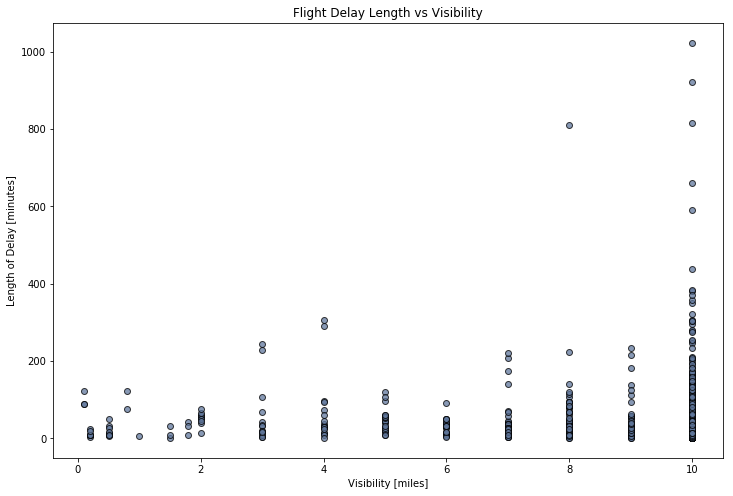

In [10]:
plt.figure(figsize=(12,8))
plt.scatter(plots["Visibility"],plots["WEATHER_DELAY"],
            alpha = 0.75,
            edgecolor = "black")
plt.title("Flight Delay Length vs Visibility")
plt.xlabel("Visibility [miles]")
plt.ylabel("Length of Delay [minutes]")
#plt.plot(x, m*x + b, '-')
plt.show()

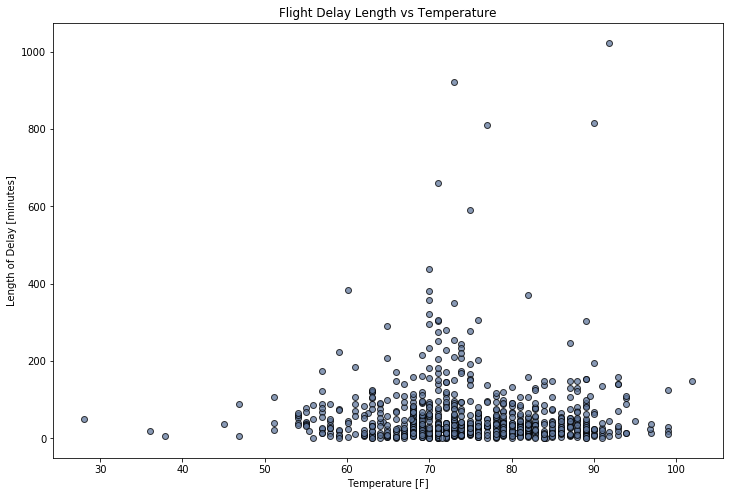

In [11]:
plt.figure(figsize=(12,8))
plt.scatter(plots["Temp"],plots["WEATHER_DELAY"],
            alpha = 0.75,
            edgecolor = "black")
plt.title("Flight Delay Length vs Temperature")
plt.xlabel("Temperature [F]")
plt.ylabel("Length of Delay [minutes]")
plt.show()

In [12]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import scipy
#regr = linear_model.LinearRegression()
#regr.fit(pressure_floats, delay_floats)
from pandas.plotting import scatter_matrix
#import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [13]:
ml = pd.DataFrame(weather_map_df.loc[:,["Wind","Pressure","Visibility","Temp","Delay Bins"]])
bins = [0, 15, 30, 45, 60, 120, 180,360,100000]
labels = ["< 15","15< x <30","30,45","45,60","60,120","120,180","180,360","> 360"]
weather_map_df["Delay Bins"] = pd.cut(weather_map_df["WEATHER_DELAY"], bins=bins, labels = labels)

ml = pd.DataFrame(weather_map_df.loc[:,["Wind","Pressure","Visibility","Temp","Delay Bins"]])
ml.head()

,Wind,Pressure,Visibility,Temp,Delay Bins
0,11.5,29.80,10.0,80.1,"60,120"
1,9.2,29.90,10.0,82.9,15< x <30
2,9.2,29.86,10.0,82.9,"60,120"
3,12.7,29.89,10.0,88.0,"30,45"
4,6.9,29.88,7.0,75.9,15< x <30


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


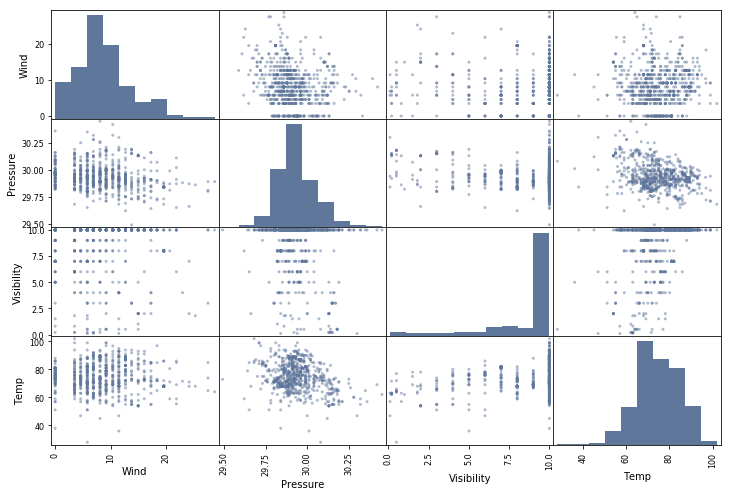

In [14]:
plt.figure(figsize = (15,8))

scatter_matrix(ml,figsize = (12,8))
ax1 = plt.subplot(442)
ax1.set_xlim([29.5,30.5])
plt.show()

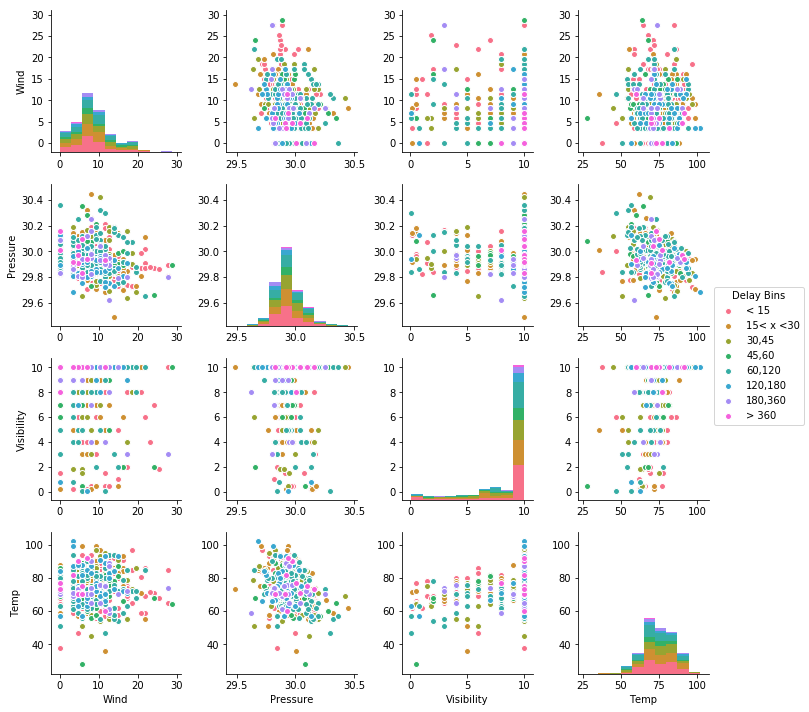

In [15]:
import seaborn as sns
sns.pairplot(ml, hue = "Delay Bins")
plt.show()

In [16]:
array = ml.values
x = array[:,0:4]
y = array[:,4]
validation_size = 0.20
seed = 7
scoring = "accuracy"
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x, y, test_size=validation_size, random_state=seed)

In [20]:
array = ml.values

x = array[:,0:4]

y = array[:,4]

validation_size = 0.20
seed = 7
scoring = "accuracy"
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x, y, test_size=validation_size, random_state=seed)

In [21]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    perc = round(cv_results.mean()*100,2)  ## taking the mean becuse it is passing ten times
    std = round(cv_results.std(),2)
    msg = f"{name} has an accuracy percentage of {perc}% and a standard deviation of {std}"
    #msg = "%s: %f (%f)" % (name, round(cv_results.mean()*100, cv_results.std())
    print(msg)

LR has an accuracy percentage of 22.78% and a standard deviation of 0.07
LDA has an accuracy percentage of 23.09% and a standard deviation of 0.06
KNN has an accuracy percentage of 17.62% and a standard deviation of 0.04
CART has an accuracy percentage of 22.75% and a standard deviation of 0.04
NB has an accuracy percentage of 9.61% and a standard deviation of 0.04
SVM has an accuracy percentage of 21.8% and a standard deviation of 0.06


Results
SVM, CART and KNN are our top two finishers:
SVM is "Support Vector Machines" - attempts to create a hyperplane separating classifications, and assigns test data a classification based on where in relation to the hyperplane that point lies
CART is "Decision Tree" - attempts to create a series of hierachichal decisions to lead to a classification
KNN is "k-Nearest Neighbot" - attemps to classify test data by analyzing nearest known data 
Analysis
These models are really bad...
Consistently less than 30% accuracy does not allow us to confidently classify delay ranges based on weather input at this time

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


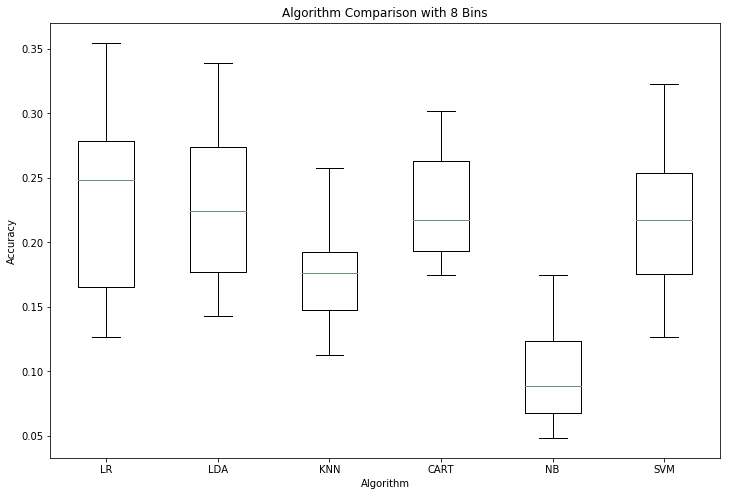

In [22]:
# Compare Algorithms
fig = plt.figure(figsize = (12,8))
#fig.suptitle('Algorithm Comparison')
plt.title("Algorithm Comparison with 8 Bins")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
#plt.y_ticks
plt.show()

In [23]:
# Compare Algorithms
# Make predictions on validation dataset

knn = KNeighborsClassifier()
svm = SVC()
lr = LogisticRegression()
lda = LinearDiscriminantAnalysis()
cart = DecisionTreeClassifier()
nb = GaussianNB()
tests = [knn, svm, lr, lda, cart, nb]
for test in tests:
    test.fit(x_train, y_train)
    predictions = test.predict(x_valid)
    print("Accuracy of " + str(test) + ": " + str((round(accuracy_score(y_valid, predictions)*100,2))) + "%")
    print("=============")
    print("CONFUSION MATRIX")
    print(confusion_matrix(y_valid, predictions))
    #print(classification_report(y_valid, predictions))


Accuracy of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'): 22.29%
CONFUSION MATRIX
[[ 0  2  0  2  1  1  4  0]
 [ 1 11  1  7  0  6  5  0]
 [ 0  0  1  1  1  1  3  0]
 [ 1  7  2  6  1  3  6  0]
 [ 1  1  0  3  2  0  3  0]
 [ 1  5  1  9  4  7  5  1]
 [ 1 16  2  4  2  4  8  0]
 [ 0  1  0  1  0  1  0  0]]
Accuracy of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False): 28.03%
CONFUSION MATRIX
[[ 0  3  0  0  0  3  4  0]
 [ 0 10  0  3  0  5 13  0]
 [ 0  0  0  1  0  0  6  0]
 [ 0  8  1  1  0  3 13  0]
 [ 0  0  0  1  0  0  9  0]
 [ 0  3  0  2  1  7 20  0]
 [ 0  6  1  1  0  3 26  0]
 [ 0  0  0  2  0  0  1  0]]
Accuracy of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          inte

# TIME OF DAY AND DAY OF WEEK DELAYS

In [13]:
#analysis of delays by time of day and day of the week 
all_delays_df = weather_df.loc[(weather_df["DEP_DELAY"]>0),:]
all_delays_df.reset_index(inplace=True)
all_delays_df.head()

,index,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,HUB_SIZE,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_HUB_SIZE,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME
0,13,2017,3,9,25,1,9/25/2017,B6,20409,B6,N337JB,1067,10721,1072102,30721,BOS,L,"Boston, MA",MA,25,Massachusetts,13,10994,1099402,30994,CHS,S,"Charleston, SC",SC,45,South Carolina,37,1359,1404.0,5.0,5.0,0.0,0.0,1300-1359,13.0,1417.0,1609.0,7.0,1626,1616.0,-10.0,0.0,0.0,-1.0,1600-1659,0,NaN,0,147,132.0,112.0,1,818,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18,2017,3,9,25,1,9/25/2017,B6,20409,B6,N608JB,1078,12889,1288903,32211,LAS,L,"Las Vegas, NV",NV,32,Nevada,85,10721,1072102,30721,BOS,L,"Boston, MA",MA,25,Massachusetts,13,1205,1219.0,14.0,14.0,0.0,0.0,1200-1259,17.0,1236.0,2031.0,10.0,2016,2041.0,25.0,25.0,1.0,1.0,2000-2059,0,NaN,0,311,322.0,295.0,1,2381,10,14.0,0.0,11.0,0.0,0.0,NaN,NaN,NaN
2,24,2017,3,9,25,1,9/25/2017,B6,20409,B6,N612JB,1097,10721,1072102,30721,BOS,L,"Boston, MA",MA,25,Massachusetts,13,10397,1039705,30397,ATL,L,"Atlanta, GA",GA,13,Georgia,34,912,1003.0,51.0,51.0,1.0,3.0,0900-0959,17.0,1020.0,1225.0,7.0,1206,1232.0,26.0,26.0,1.0,1.0,1200-1259,0,NaN,0,174,149.0,125.0,1,946,4,16.0,0.0,0.0,0.0,10.0,NaN,NaN,NaN
3,27,2017,3,9,25,1,9/25/2017,B6,20409,B6,N517JB,1100,13495,1349503,33495,MSY,M,"New Orleans, LA",LA,22,Louisiana,72,10721,1072102,30721,BOS,L,"Boston, MA",MA,25,Massachusetts,13,1506,1508.0,2.0,2.0,0.0,0.0,1500-1559,10.0,1518.0,1909.0,7.0,1922,1916.0,-6.0,0.0,0.0,-1.0,1900-1959,0,NaN,0,196,188.0,171.0,1,1368,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,28,2017,3,9,25,1,9/25/2017,B6,20409,B6,N517JB,1101,10721,1072102,30721,BOS,L,"Boston, MA",MA,25,Massachusetts,13,13495,1349503,33495,MSY,M,"New Orleans, LA",LA,22,Louisiana,72,1150,1156.0,6.0,6.0,0.0,0.0,1100-1159,25.0,1221.0,1424.0,4.0,1425,1428.0,3.0,3.0,0.0,0.0,1400-1459,0,NaN,0,215,212.0,183.0,1,1368,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
weekday_delay_df = pd.DataFrame(all_delays_df.loc[:,["FL_DATE","DAY_OF_WEEK","UNIQUE_CARRIER",
                                                "ORIGIN","DEP_TIME","DEP_TIME_BLK","DEP_DELAY"]])
weekday_delay_df.head()

,FL_DATE,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEP_TIME,DEP_TIME_BLK,DEP_DELAY
0,9/25/2017,1,B6,BOS,1404.0,1300-1359,5.0
1,9/25/2017,1,B6,LAS,1219.0,1200-1259,14.0
2,9/25/2017,1,B6,BOS,1003.0,0900-0959,51.0
3,9/25/2017,1,B6,MSY,1508.0,1500-1559,2.0
4,9/25/2017,1,B6,BOS,1156.0,1100-1159,6.0


In [15]:
grouped_weekday = weekday_delay_df.groupby(["DAY_OF_WEEK"])
grouped_weekday_delay = pd.DataFrame(grouped_weekday["DEP_DELAY"].mean())
grouped_weekday_delay

,DEP_DELAY
DAY_OF_WEEK,
1,34.774388
2,33.936037
3,30.484701
4,33.781026
5,31.885429
6,25.050625
7,30.901735


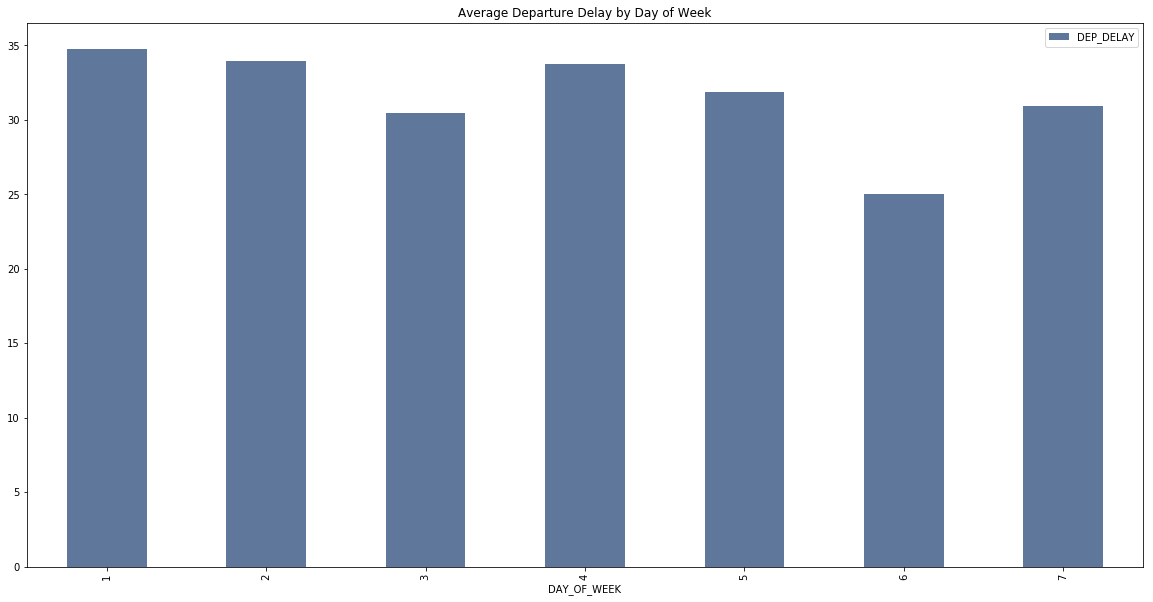

In [16]:
#analysis of departure delays by day of week
grouped_weekday_delay.plot(kind='bar', title='Average Departure Delay by Day of Week', figsize=(20,10))
plt.savefig("delaybyday.png")
plt.show()

In [136]:
#plot delays by timeblock
grouped_timeblk = weekday_delay_df.groupby(["DEP_TIME_BLK"])
timeblk = pd.DataFrame(grouped_timeblk["DEP_DELAY"].mean())

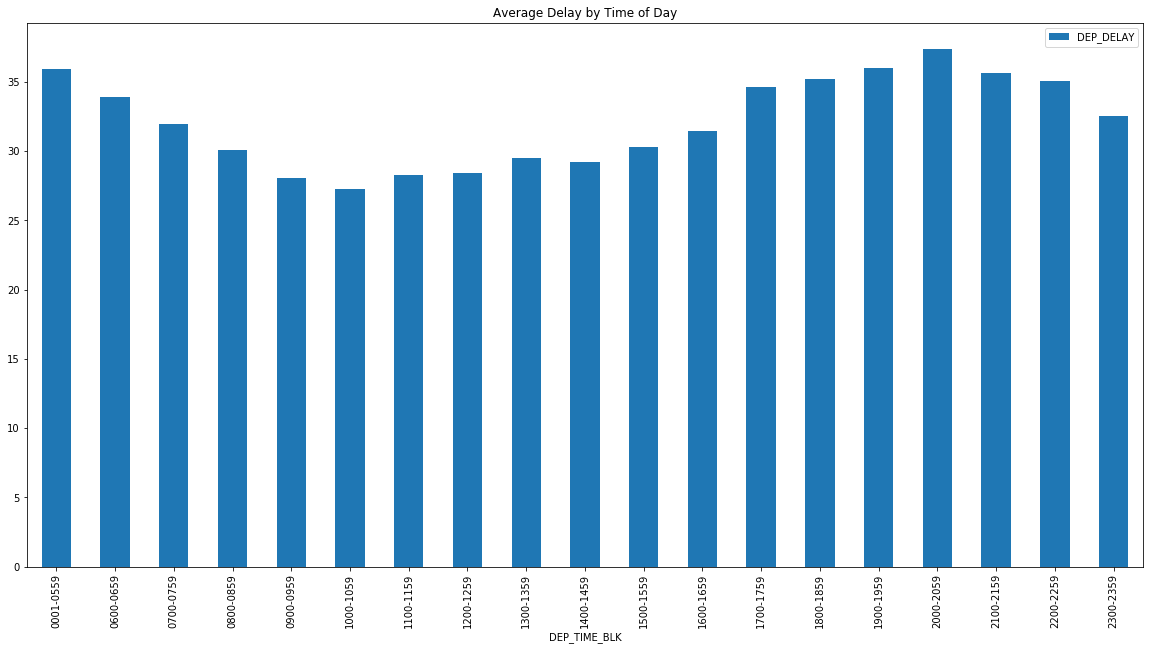

In [139]:
timeblk.plot(kind='bar', title='Average Delay by Time of Day', figsize=(20,10))
plt.savefig("delaybytimeblock.png")
plt.show()

In [2]:
#analysis of flight delays by hub size
# Create reference to CSV file
csv_path_hub = "cy16-commercial-service-enplanements.csv"

# Import the CSV into a pandas DataFrame
hub_df = pd.read_csv(csv_path_hub, low_memory=False)
hub_df.head()

,Rank,RO,ST,Locid,City,Airport Name,S/L,Hub,CY 16 Enplanements,CY 15 Enplanements,% Change
0,1.0,SO,GA,ATL,Atlanta,Hartsfield - Jackson Atlanta International,P,L,"50,501,858","49,340,732",2.35%
1,2.0,WP,CA,LAX,Los Angeles,Los Angeles International,P,L,"39,636,042","36,351,272",9.04%
2,3.0,GL,IL,ORD,Chicago,Chicago O'Hare International,P,L,"37,589,899","36,305,668",3.54%
3,4.0,SW,TX,DFW,Fort Worth,Dallas-Fort Worth International,P,L,"31,283,579","31,589,839",-0.97%
4,5.0,EA,NY,JFK,New York,John F Kennedy International,P,L,"29,239,151","27,782,369",5.24%


In [11]:
weather_hub_df = pd.DataFrame(weather_df.loc[:,["FL_DATE","CARRIER","ORIGIN","HUB_SIZE","ORIGIN_STATE_ABR","DEST","DEST_HUB_SIZE","DEST_STATE_ABR","DEP_TIME","WEATHER_DELAY","CARRIER_DELAY","NAS_DELAY","SECURITY_DELAY","CANCELLATION_CODE"]])
weather_hub_df.head()

,FL_DATE,CARRIER,ORIGIN,HUB_SIZE,ORIGIN_STATE_ABR,DEST,DEST_HUB_SIZE,DEST_STATE_ABR,DEP_TIME,WEATHER_DELAY,CARRIER_DELAY,NAS_DELAY,SECURITY_DELAY,CANCELLATION_CODE
0,9/25/2017,B6,SJU,M,PR,STT,S,VI,NaN,NaN,NaN,NaN,NaN,C
1,9/25/2017,B6,AUS,M,TX,BOS,L,MA,1801.0,NaN,NaN,NaN,NaN,NaN
2,9/25/2017,B6,BOS,L,MA,AUS,M,TX,701.0,NaN,NaN,NaN,NaN,NaN
3,9/25/2017,B6,JFK,L,NY,SAV,S,GA,1552.0,NaN,NaN,NaN,NaN,NaN
4,9/25/2017,B6,SAV,S,GA,JFK,L,NY,1902.0,NaN,NaN,NaN,NaN,NaN


In [101]:
hub_weather_delays_df = weather_hub_df.loc[(((weather_hub_df["WEATHER_DELAY"] > 0) | (weather_hub_df["CARRIER_DELAY"] > 0) | (weather_hub_df["NAS_DELAY"] > 0) | (weather_hub_df["SECURITY_DELAY"] > 0)) & ((weather_hub_df["HUB_SIZE"] != "N") & (weather_hub_df["HUB_SIZE"] != "None")) & ((weather_hub_df["DEST_HUB_SIZE"] != "N") & (weather_hub_df["DEST_HUB_SIZE"] != "None")))]
hub_weather_delays_df.reset_index(inplace=True)
hub_weather_delays_df.head()

,index,FL_DATE,CARRIER,ORIGIN,HUB_SIZE,ORIGIN_STATE_ABR,DEST,DEST_HUB_SIZE,DEST_STATE_ABR,DEP_TIME,WEATHER_DELAY,CARRIER_DELAY,NAS_DELAY,SECURITY_DELAY,CANCELLATION_CODE
0,18,9/25/2017,B6,LAS,L,NV,BOS,L,MA,1219.0,0.0,14.0,11.0,0.0,NaN
1,24,9/25/2017,B6,BOS,L,MA,ATL,L,GA,1003.0,0.0,16.0,0.0,0.0,NaN
2,35,9/25/2017,B6,PDX,L,OR,LGB,S,CA,817.0,0.0,79.0,0.0,0.0,NaN
3,36,9/25/2017,B6,JFK,L,NY,LAX,L,CA,2129.0,0.0,76.0,0.0,0.0,NaN
4,46,9/25/2017,B6,BDL,M,CT,PBI,M,FL,1044.0,0.0,5.0,0.0,0.0,NaN


In [102]:
hub_weather_delays_df["HUB_FLIGHT"] = hub_weather_delays_df["HUB_SIZE"] + hub_weather_delays_df["DEST_HUB_SIZE"]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [104]:
# group by flight classification 
#LL means from large origin to large destination, LM means large origin to medium destination, etc.
by_hub_size = hub_weather_delays_df.groupby('HUB_FLIGHT')
weather_delay_average = by_hub_size["WEATHER_DELAY"].mean()
weather_delay_average

HUB_FLIGHT
LL    2.828606
LM    2.583009
LS    3.164990
ML    2.214808
MM    1.346133
MS    0.639344
SL    2.085437
SM    2.038095
SS    0.346154
Name: WEATHER_DELAY, dtype: float64

In [106]:
carrier_delay_average = by_hub_size["CARRIER_DELAY"].mean()
carrier_delay_average

HUB_FLIGHT
LL    19.664661
LM    23.546719
LS    28.050050
ML    23.389952
MM    17.658194
MS    16.453552
SL    33.699354
SM    19.311111
SS    26.615385
Name: CARRIER_DELAY, dtype: float64

In [107]:
nas_delay_average = by_hub_size["NAS_DELAY"].mean()
nas_delay_average

HUB_FLIGHT
LL    20.591230
LM    10.755145
LS    10.879024
ML    19.097216
MM     5.943753
MS     5.811475
SL    25.686142
SM     6.523810
SS    11.576923
Name: NAS_DELAY, dtype: float64

In [108]:
security_delay_average = by_hub_size["SECURITY_DELAY"].mean()
security_delay_average

HUB_FLIGHT
LL    0.098805
LM    0.083148
LS    0.033702
ML    0.037797
MM    0.065441
MS    0.172131
SL    0.049618
SM    0.000000
SS    0.000000
Name: SECURITY_DELAY, dtype: float64

In [51]:
delay_df = pd.DataFrame([weather_delay_average]).T
print(delay_df)

            WEATHER_DELAY
HUB_FLIGHT               
LL               2.828606
LM               2.583009
LS               3.164990
ML               2.214808
MM               1.346133
MS               0.639344
SL               2.085437
SM               2.038095
SS               0.346154


In [110]:
delay_df = pd.DataFrame([weather_delay_average, carrier_delay_average, nas_delay_average]).T
delay_df

,WEATHER_DELAY,CARRIER_DELAY,NAS_DELAY
HUB_FLIGHT,,,
LL,2.828606,19.664661,20.591230
LM,2.583009,23.546719,10.755145
LS,3.164990,28.050050,10.879024
ML,2.214808,23.389952,19.097216
MM,1.346133,17.658194,5.943753
MS,0.639344,16.453552,5.811475
SL,2.085437,33.699354,25.686142
SM,2.038095,19.311111,6.523810
SS,0.346154,26.615385,11.576923


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


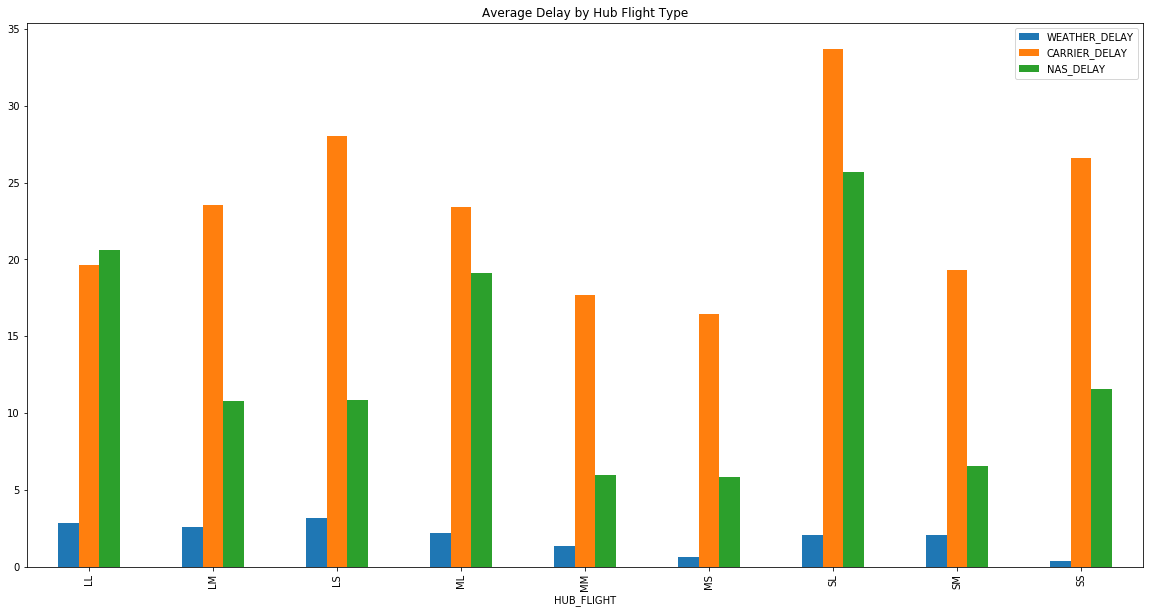

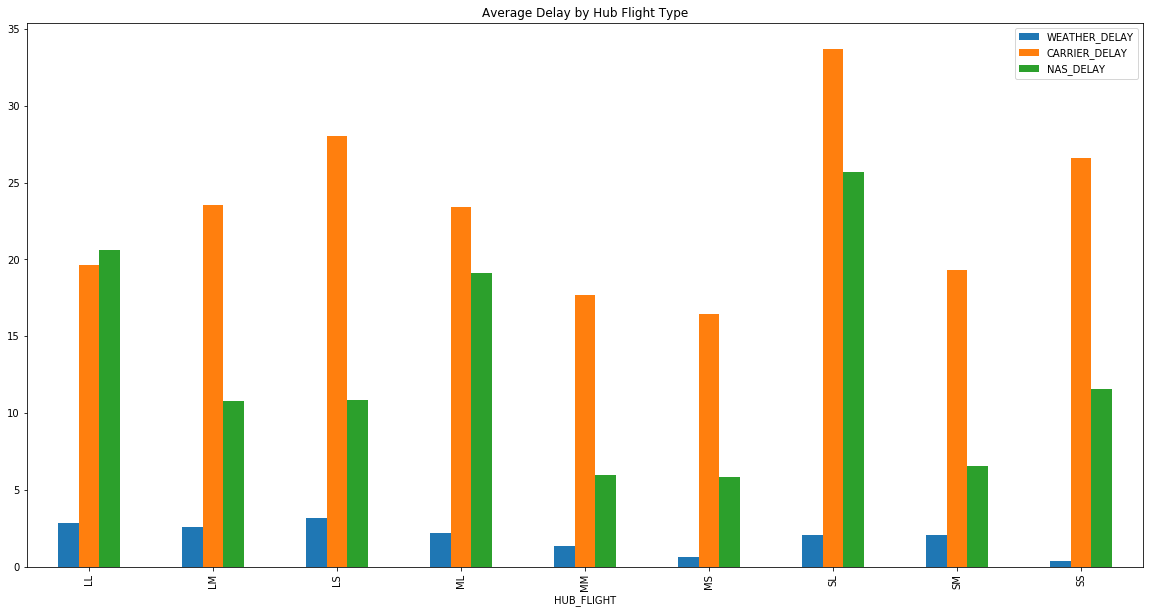

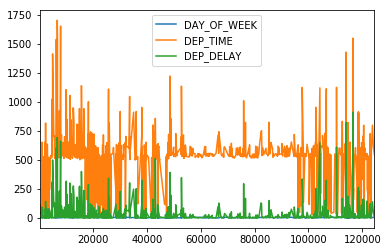

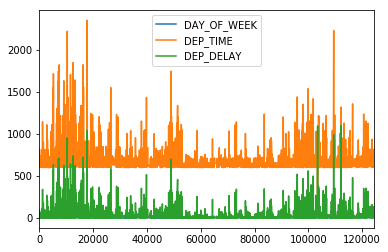

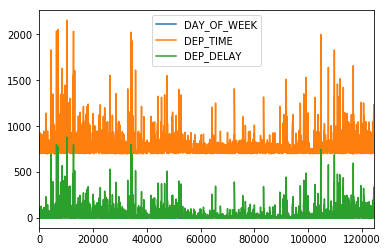

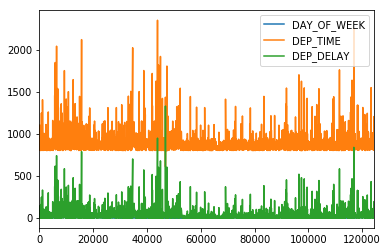

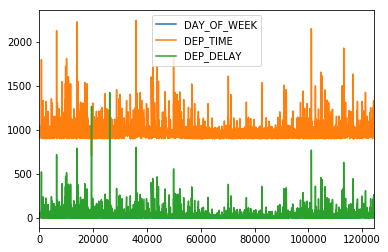

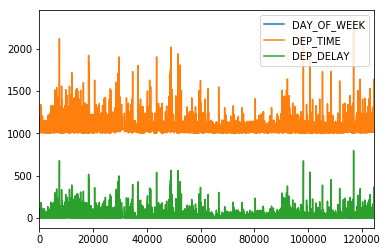

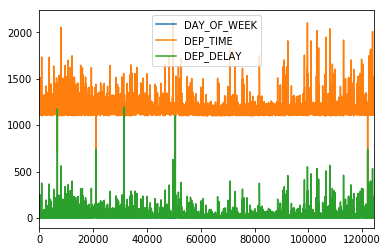

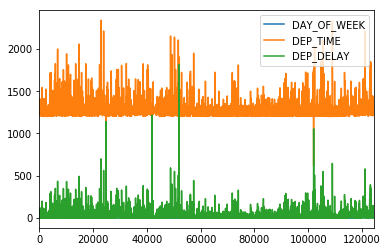

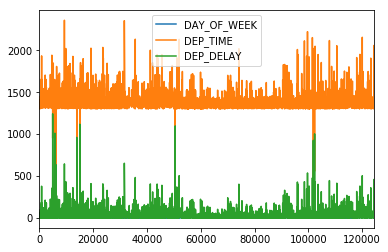

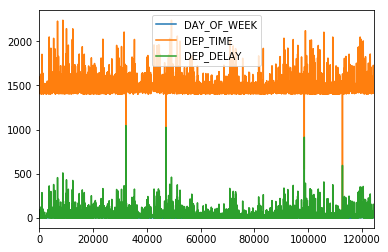

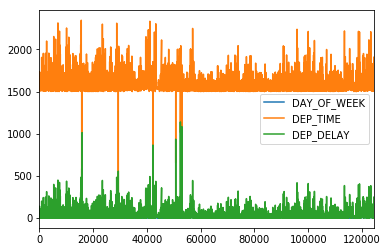

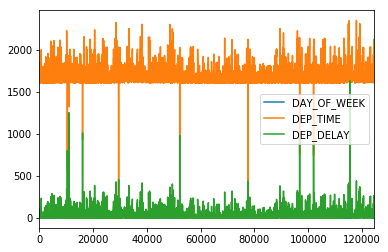

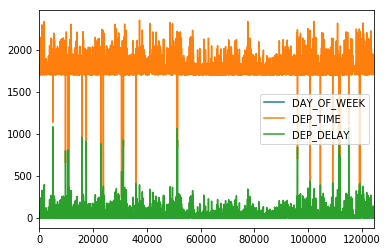

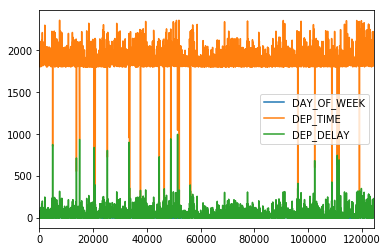

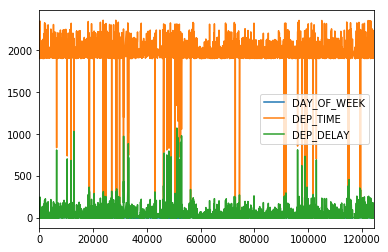

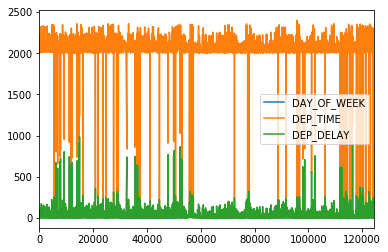

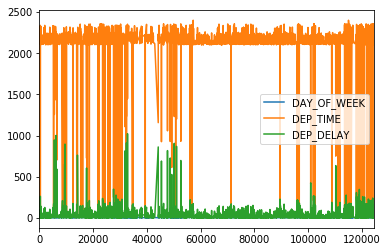

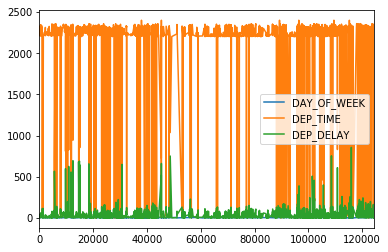

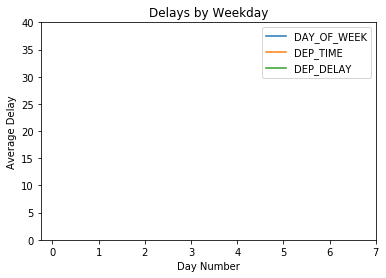

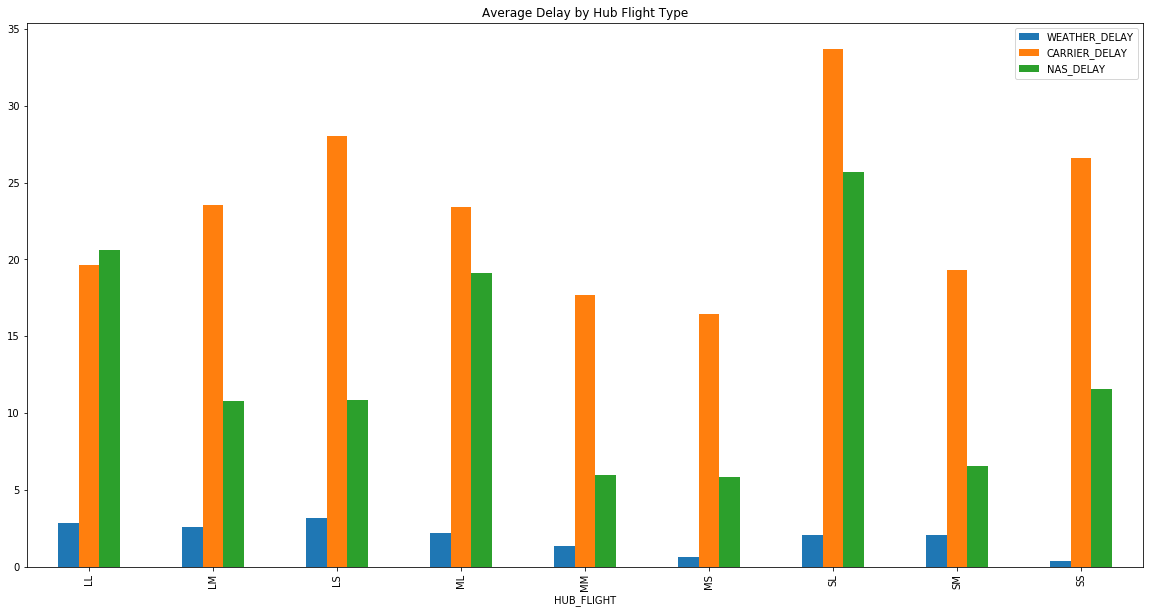

In [135]:
#plot delays by hub flight classifications
delay_df.plot(kind='bar', title='Average Delay by Hub Flight Type', figsize=(20,10))
plt.savefig("delaybyhub.png")
plt.show()